The oldest version of this file is local.

In [2]:
from scipy.stats import gaussian_kde
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3) 
plt.rcParams["axes.grid"] = True        
plt.rcParams["figure.autolayout"] = True 
import pickle
import seaborn as sns
from itertools import cycle
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import pandas as pd
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D 
import torch
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import torch.nn as nn
from stable_baselines3 import DQN
import re
import gymnasium as gym

# Aux Functions

In [3]:
def plotly_eye_to_view_init(eye):
    """
    Convert a Plotly camera 'eye' dict to Matplotlib view_init(elev, azim).
    eye: dict like {'x': ..., 'y': ..., 'z': ...}
    """
    x, y, z = eye["x"], eye["y"], eye["z"]
    azim = np.degrees(np.arctan2(y, x))
    r_xy = np.hypot(x, y)
    elev = np.degrees(np.arctan2(z, r_xy))
    return elev, azim

In [4]:
def save_action_surface_pdf(
    elev, azim, action_idx, q_values, n_grid, time_pct, inv_pct, filename="q_surface_action.pdf",
    global_vmin=None, global_vmax=None, cmap="plasma"
):
    Z = q_values[:, action_idx].reshape(n_grid, n_grid)

    vmin = np.nanmin(Z) if global_vmin is None else global_vmin
    vmax = np.nanmax(Z) if global_vmax is None else global_vmax

    # Bigger canvas; we’ll leave generous margins
    fig = plt.figure(figsize=(8.0, 6.0))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_proj_type('ortho')  # cleaner text (less perspective distortion)

    # Surface colored by Q-value (viridis ~ Plotly)
    surf = ax.plot_surface(
        time_pct, inv_pct, Z,
        cmap=cmap, vmin=vmin, vmax=vmax,
        rstride=1, cstride=1, linewidth=0, antialiased=True
    )

    # Labels & ticks
    ax.set_xlabel("Time (%)", labelpad=10, fontsize=15)
    ax.set_ylabel("Remaining Inventory (%)", labelpad=10, fontsize=15)

    ax.zaxis.set_rotate_label(False)                 # keep our rotation
    ax.set_zlabel("Q-value", rotation=90, labelpad=4, fontsize=15)  # bottom→top

    ax.set_xlim(0, 100); ax.set_ylim(0, 100)
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_yticks(np.arange(0, 101, 20))
    ax.tick_params(pad=4)
    ax.set_box_aspect((1, 1, 0.8))
    ax.view_init(elev=elev, azim=azim)

    # Slim colorbar with clear label
    cbar = fig.colorbar(surf, ax=ax, shrink=0.82, pad=0.10)
    # cbar.set_label("Q-value")

    # Give extra room so axis labels never clip
    fig.subplots_adjust(left=0.16, right=0.92, bottom=0.16, top=0.98)

    # Safe vector export
    fig.savefig(filename, format="pdf", bbox_inches="tight", pad_inches=0.30)
    plt.close(fig)


In [5]:
def compute_t_test(types, run_names, size=20_000, reference='ddqn', side='greater'):
    dic_is = {}
    for typ, run_name in zip(types, run_names):
        with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{run_name}.pkl', 'rb') as f:
            dic = pickle.load(f)
        final_is = np.array(dic['final_is'])
        final_is = np.random.choice(final_is, size=size, replace=False)
        dic_is[typ] = final_is

    for typ in types:
        if typ != reference:
            t_stat, p_value = stats.ttest_ind(dic_is[reference], dic_is[typ], equal_var=False, alternative=side)
            print(f'T-test between {reference} and {typ}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')
            if p_value < 0.05:
                print(f'Statistically significant difference between {reference} and {typ} (p < 0.05)')
            print('\n')


In [6]:
def plot_mean_distance_boxplots(executed, trader_times, run_id=None):
    """
    For each run in `executed` (a dict of run_id → list of executed volumes),
    compute the mean number of zeros between consecutive non-zero volumes
    (i.e. the “gap” length), group those means by the length of the run,
    and draw a boxplot for each possible run length 1..len(trader_times)-1.
    
    Parameters
    ----------
    executed : dict[int, list[int]]
        Keys are run IDs; values are lists of volumes (integers) executed
        at each trader time step (zeros allowed).
    trader_times : Sequence
        Any sequence whose length defines the maximum possible run length.
    """
    # x-axis values: 1, 2, ..., len(trader_times)-1
    x_vals = list(range(1, len(trader_times)))
    
    def mean_zero_gap(vols):
        # find indices of non-zero executions
        idxs = [i for i, v in enumerate(vols) if v != 0]
        # need at least two to form a “gap”
        if len(idxs) < 2:
            return None
        # gap = count of zeros between each pair of non-zeros
        gaps = [idxs[i+1] - idxs[i] - 1 for i in range(len(idxs)-1)]
        return sum(gaps) / len(gaps)
    
    # initialize storage for each possible length
    grouped = {L: [] for L in x_vals}
    
    # compute mean gap for each run, bucket by run length
    for i, vols in executed.items():
        L = len(vols)
        if L in grouped:
            mg = mean_zero_gap(vols) 
            if mg is not None:
                grouped[L].append(mg)
    
    # prepare data & positions for boxplot (skip lengths with no data)
    data   = []
    pos    = []
    for L in x_vals:
        if grouped[L]:
            data.append(grouped[L])
            pos.append(L)
    
    # draw
    plt.figure(figsize=(5, 4))
    plt.boxplot(data, positions=pos, widths=0.6, showfliers=False)
    plt.xlabel('Episode length', fontsize=13)
    plt.ylabel('Gap Mean', fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    ax = plt.gca()
    ax.set_xlim(min(pos) - 0.5, max(pos) + 0.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True, prune='both'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    plt.tight_layout()
    plt.savefig(f"/scratch/network/te6653/qrm_optimal_execution/plots/gaps/{run_id}.pdf", bbox_inches="tight")

    plt.figure(figsize=(5, 4))
    plt.boxplot(data, positions=pos, widths=0.6)
    plt.xlabel('Episode length', fontsize=13)
    plt.ylabel('Gap Mean', fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    ax = plt.gca()
    ax.set_xlim(min(pos) - 0.5, max(pos) + 0.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True, prune='both'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    plt.tight_layout()
    plt.savefig(f"/scratch/network/te6653/qrm_optimal_execution/plots/gaps/{run_id}_outliers.pdf", bbox_inches="tight")
    plt.show()


In [7]:
def plot_intra_mean_distance_boxplots(executed, trader_times, run_id=None):
    """
    For each run in `executed` (a dict of run_id → list of executed volumes),
    compute the mean number of zeros between consecutive non-zero volumes
    (i.e. the “gap” length), group those means by the length of the run,
    and draw a boxplot for each possible run length 1..len(trader_times)-1.
    
    Parameters
    ----------
    executed : dict[int, list[int]]
        Keys are run IDs; values are lists of volumes (integers) executed
        at each trader time step (zeros allowed).
    trader_times : Sequence
        Any sequence whose length defines the maximum possible run length.
    """
    # x-axis values: 1, 2, ..., len(trader_times)-1
    x_vals = list(range(1, len(trader_times)))
    
    def var_zero_gap(vols):
        # find indices of non-zero executions
        idxs = [i for i, v in enumerate(vols) if v != 0]
        # need at least two to form a “gap”
        if len(idxs) < 2:
            return None
        # gap = count of zeros between each pair of non-zeros
        gaps = [idxs[i+1] - idxs[i] - 1 for i in range(len(idxs)-1)]
        return np.var(gaps)
    
    # initialize storage for each possible length
    grouped = {L: [] for L in x_vals}
    
    # compute mean gap for each run, bucket by run length
    for i, vols in executed.items():
        L = len(vols)
        if L in grouped:
            mg = var_zero_gap(vols) 
            if mg is not None:
                grouped[L].append(mg)
    
    # prepare data & positions for boxplot (skip lengths with no data)
    data   = []
    pos    = []
    for L in x_vals:
        if grouped[L]:
            data.append(grouped[L])
            pos.append(L)
    
    # draw
    plt.figure(figsize=(5, 4))
    plt.boxplot(data, positions=pos, widths=0.6, showfliers=False)
    plt.xlabel('Episode length', fontsize=13)
    plt.ylabel('Gap Variance', fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    ax = plt.gca()
    ax.set_xlim(min(pos) - 0.5, max(pos) + 0.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True, prune='both'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    plt.tight_layout()
    plt.savefig(f"/scratch/network/te6653/qrm_optimal_execution/plots/gaps/variance_{run_id}.pdf", bbox_inches="tight")

    plt.figure(figsize=(5, 4))
    plt.boxplot(data, positions=pos, widths=0.6)
    plt.xlabel('Episode length', fontsize=13)
    plt.ylabel('Gap Variance', fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    ax = plt.gca()
    ax.set_xlim(min(pos) - 0.5, max(pos) + 0.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True, prune='both'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    plt.tight_layout()
    plt.savefig(f"/scratch/network/te6653/qrm_optimal_execution/plots/gaps/variance_{run_id}_outliers.pdf", bbox_inches="tight")
    plt.show()


In [10]:
from itertools import cycle

def plot_overview(
    run_names,
    run_labels,
    initial_inventory,
    trader_times,
    title,
    metric='executed',
    kde_only=True,
    best_labels=None,
    run_id=None, 
    save_fig=True
):
    non_red_colors = ['C0', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    # --- Load all final_IS and inventory dicts ---
    final_is = {}
    actions = {}
    ddqn_lengths = []

    for lbl, rn in zip(run_labels, run_names):
        with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{rn}.pkl', 'rb') as f:
            dic = pickle.load(f)
        final_is[lbl] = np.asarray(dic['final_is'])
        exec_dict = dic[metric]
        actions[lbl] = exec_dict
        if lbl == 'DDQN':
            seqs = [exec_dict[i] for i in sorted(exec_dict)]
            ddqn_lengths = [len(seq) for seq in seqs]

    # --- Prepare x-grids for IS plots ---
    maxi = max(np.max(np.abs(v)) for v in final_is.values())
    x_sym = np.linspace(-maxi, maxi, 1000)
    all_vals = np.concatenate(list(final_is.values()))
    x_auto = np.linspace(all_vals.min(), all_vals.max(), 1000)

    # filename prefix
    safe_title = re.sub(r'[^-\w]+', '_', title) if title else 'overview'
    prefix = f"{safe_title}" + (f"_{run_id}" if run_id is not None else "")

    # ===============================
    # Figure 1: IS KDE (all methods), symmetric limits
    # ===============================
    fig1, ax1 = plt.subplots(figsize=(4,3))
    labels_to_plot = final_is.keys()
    if not kde_only:
        for lbl in labels_to_plot:
            vals = final_is[lbl]
            ax1.hist(vals, bins=27, density=True, alpha=0.3, label=f'{lbl} hist')

    for kk, lbl in enumerate(labels_to_plot):
        print(f'[{lbl}] IS: mean={final_is[lbl].mean():.3f}, std={final_is[lbl].std():.3f} \n')
        vals = final_is[lbl]
        kde = gaussian_kde(vals)
        y = kde(x_sym)
        if lbl != 'DDQN':
            ax1.plot(x_sym, y, label=lbl, color=non_red_colors[kk])
        else:
            ax1.plot(x_sym, y, linestyle='--', color='C3', label=lbl)

    # ax1.set_title(f"{title} — IS (all methods, symmetric)", fontsize=11)
    ax1.set_xlabel('Implementation Shortfall')
    ax1.set_ylabel('Density')
    extra = 1
    ax1.set_xlim(x_sym.min() + extra, x_sym.max() - extra)
    ax1.grid(True)
    ax1.legend()
    fig1.tight_layout()
    if save_fig:
        fig1.savefig(f"/scratch/network/te6653/qrm_optimal_execution/plots/overview/{run_id}_subplot_1.pdf", bbox_inches="tight")


    # ===============================
    # Figure 2: IS KDE (best performing) auto-limits
    # ===============================
    fig2, ax2 = plt.subplots(figsize=(4,3))
    labels_to_plot = best_labels if (best_labels is not None) else final_is.keys()

    if not kde_only:
        for lbl in labels_to_plot:
            vals = final_is[lbl]
            ax2.hist(vals, bins=27, density=True, alpha=0.3, label=f'{lbl} hist')

    for lbl in labels_to_plot:
        vals = final_is[lbl]
        kde = gaussian_kde(vals)
        y = kde(x_auto)
        if lbl != 'DDQN':
            ax2.plot(x_auto, y, label=lbl)
        else:
            ax2.plot(x_auto, y, linestyle='--', color='C3', label=lbl)

    # ax2.set_title(f"{title} — IS (best performing, auto-limits)", fontsize=11)
    ax2.set_xlabel('Implementation Shortfall')
    ax2.set_ylabel('Density')
    ax2.grid(True)
    ax2.legend()
    fig2.tight_layout()
    if save_fig:
        fig2.savefig(f"/scratch/network/te6653/qrm_optimal_execution/plots/overview/{run_id}_subplot_2.pdf", bbox_inches="tight")

    # ===============================
    # Figure 3: Avg. Inventory Trajectory (μ ± σ/2)
    # ===============================
    fig3, ax3 = plt.subplots(figsize=(4,3))
    for kk, (lbl, exec_dict) in enumerate(actions.items()):
        seqs = [exec_dict[i] for i in sorted(exec_dict)]
        inv = np.zeros((len(seqs), len(trader_times)))
        for i, seq in enumerate(seqs):
            inv[i, :len(seq)] = seq
        inv = np.cumsum(inv, axis=1) / initial_inventory

        # Stats
        mask = inv[:, -1] < 1 # Runs that did not reach full inventory
        pct = np.mean(mask) * 100
        if np.any(mask):
            inv_abs = inv[mask] * initial_inventory
            missing = initial_inventory - inv_abs[:, -1]
            avg_missing = np.mean(missing)
            std_missing = np.std(missing)
            max_missing = np.max(missing)
            print(f'[{lbl}] {pct:.4f}% of runs did not reach full inventory')
            print(f'    Missing volume: avg={avg_missing:.2f}, std={std_missing:.2f}, max={max_missing:.2f}\n')
        else:
            print(f'[{lbl}] 0.0000% of runs did not reach full inventory')

        mu = inv.mean(axis=0)
        s = inv.std(axis=0)
        x_vals = np.arange(1, len(trader_times) + 1)
        if lbl != 'DDQN':
            line, = ax3.plot(x_vals, mu, label=lbl, color=non_red_colors[kk])
            ax3.fill_between(x_vals, mu - s/2, mu + s/2, alpha=0.2, color=non_red_colors[kk])
        else:
            line, = ax3.plot(x_vals, mu, linestyle='--', color='C3', label=lbl)
            ax3.fill_between(x_vals, mu - s/2, mu + s/2, alpha=0.2, color='C3')

    ax3.set_xlim(1, len(trader_times))
    ax3.set_xlabel('Trader Step')
    ax3.set_ylabel('Executed Inventory (%)')
    # ax3.set_title(f"{title} — Avg. Inventory Trajectory (μ ± σ/2)", fontsize=11)
    ax3.grid(True)
    ax3.legend()
    fig3.tight_layout()
    if save_fig:
        fig3.savefig(f"/scratch/network/te6653/qrm_optimal_execution/plots/overview/{run_id}_subplot_3.pdf", bbox_inches="tight")

    # ===============================
    # Figure 4: DDQN Episode Lengths (PDF + ECDF)
    # ===============================
    times = np.array(ddqn_lengths)
    fig4, ax4 = plt.subplots(figsize=(4,3))
    max_len = len(trader_times)
    bin_edges = np.arange(0.5, max_len + 1.5, 1)

    ax4.hist(times, bins=bin_edges, density=True, alpha=0.9, color='C0', label='Density')
    ax4b = ax4.twinx()
    sorted_t = np.sort(times)
    ecdf = np.arange(1, len(sorted_t) + 1) / len(sorted_t)
    ax4b.step(sorted_t, ecdf, where='post', color='k', label='ECDF')

    ax4.set_xlabel('Trader Step')
    ax4.set_ylabel('Density', color='k')
    ax4b.set_ylabel('ECDF', color='k')
    # ax4.set_title(f"{title} — Episode Length", fontsize=11)
    ax4.grid(True, which='both')
    ax4.set_xlim(0.5, max_len + 0.5)
    ax4b.set_xlim(ax4.get_xlim())
    ax4.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True, prune='both'))
    ax4.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    # single combined legend
    h1, l1 = ax4.get_legend_handles_labels()
    h2, l2 = ax4b.get_legend_handles_labels()
    ax4.legend(h1 + h2, l1 + l2, loc='lower right')

    fig4.tight_layout()
    if save_fig:
        fig4.savefig(f"/scratch/network/te6653/qrm_optimal_execution/plots/overview/{run_id}_subplot_4.pdf", bbox_inches="tight")
    plt.show()


# RL Runs Results

## trivial slopes 5 dim: k3631p6d

### General

In [ ]:
run_id = 'k3631p6d'
state_dim = 5
action_dim = 2
initial_inventory = 25
th = 600
ts = 25
types = ['twap', 'front_load', 'best_volume_2', 'best_volume_3', 'best_volume_4', 'ddqn']
types = ['twap', 'front_load', 'best_volume_4', 'ddqn']
run_ids = ['c1'] * (len(types)-1) + [run_id]
run_labels = ['TWAP', 'BV1', 'BV4', 'DDQN']
best_labels = ['TWAP', 'BV1', 'BV4', 'DDQN']
metric='executed'

### --------------- #############################################

trader_times_full = np.concatenate(([0], np.arange(0, th + ts, ts)))
trader_times = trader_times_full[1:]

run_names = [f'{type}_{ri}' for type, ri in zip(types, run_ids)]
title = f'{run_id}'

final_is = {}
actions = {}
ddqn_lengths = []

for lbl, rn in zip(run_labels, run_names):
    with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{rn}.pkl', 'rb') as f:
        dic = pickle.load(f)
    final_is[lbl] = np.asarray(dic['final_is'])
    exec_dict = dic[metric]
    actions[lbl] = exec_dict
    if lbl == 'DDQN':
        seqs = [exec_dict[i] for i in sorted(exec_dict)]
        ddqn_lengths = [len(seq) for seq in seqs]

[DDQN] 100.0000% of runs did not reach full inventory
    Missing volume: avg=5.00, std=0.00, max=5.00



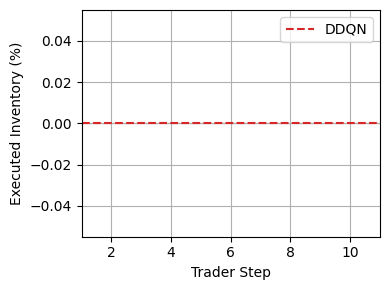

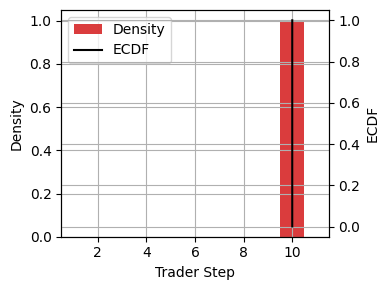

: 

In [ ]:
run_id = 'k3631p6d'
state_dim = 5
action_dim = 2
initial_inventory = 5
th = 1000
ts = 100
types = ['ddqn']
run_ids = ['c1'] * (len(types)-1) + [run_id]
run_labels = ['DDQN']
best_labels = ['DDQN']

### --------------- #############################################

trader_times_full = np.concatenate(([0], np.arange(0, th + ts, ts)))
trader_times = trader_times_full[1:]

run_names = [f'{type}_{ri}' for type, ri in zip(types, run_ids)]
title = f'{run_id}'

### --------------- #############################################

plot_overview(
    run_names,
    run_labels,
    initial_inventory,
    trader_times,
    title,
    metric='executed',
    kde_only=True, 
    best_labels=best_labels, 
    run_id=run_id, save_fig=False)

run_name = f'ddqn_{run_id}'
with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{run_name}.pkl', 'rb') as f:
    dic = pickle.load(f)
executed = dic['executed']

# plot_mean_distance_boxplots(executed, trader_times_full, run_id)
# plot_intra_mean_distance_boxplots(executed, trader_times_full, run_id)

## 3-dim: kfryeeez

### General

[A&C] IS: mean=-0.365, std=0.652 

[aVWAP1] IS: mean=-0.413, std=0.279 

[aVWAP2] IS: mean=-0.408, std=0.342 

[aVWAP3] IS: mean=-0.400, std=0.388 

[aVWAP4] IS: mean=-0.399, std=0.437 

[DDQN] IS: mean=-0.386, std=0.473 

[A&C] 0.0000% of runs did not reach full inventory
[aVWAP1] 0.0000% of runs did not reach full inventory
[aVWAP2] 0.0000% of runs did not reach full inventory
[aVWAP3] 0.0050% of runs did not reach full inventory
    Missing volume: avg=4.00, std=0.00, max=4.00

[aVWAP4] 0.2650% of runs did not reach full inventory
    Missing volume: avg=2.51, std=1.91, max=9.00

[DDQN] 0.0000% of runs did not reach full inventory


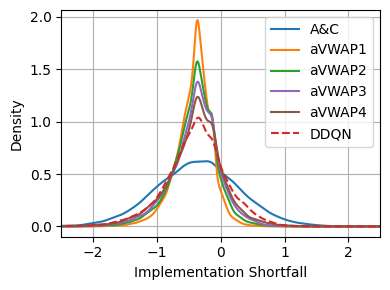

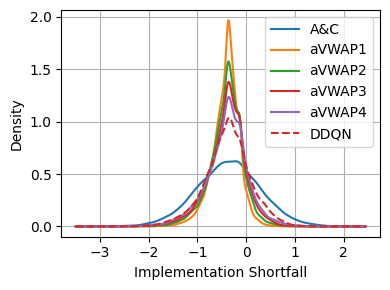

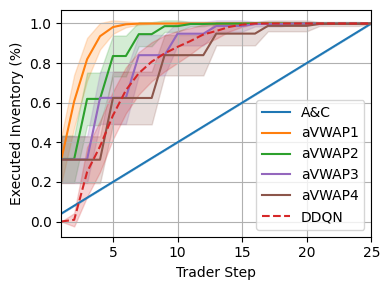

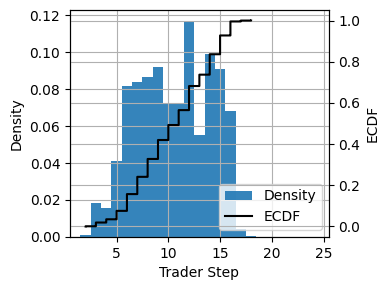

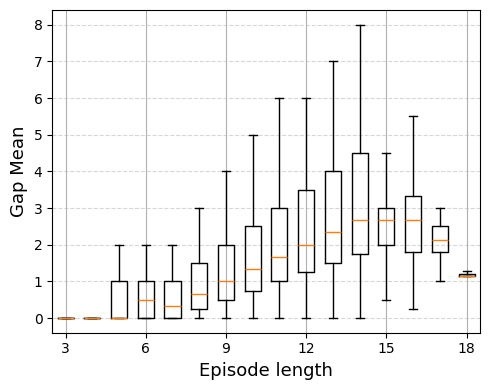

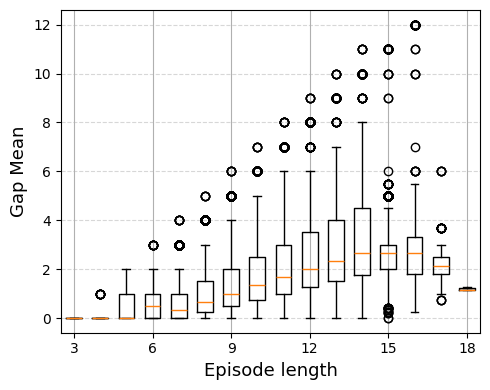

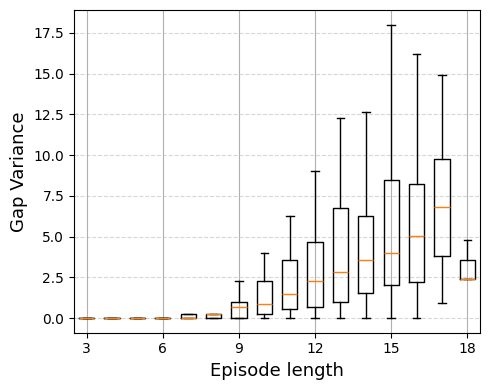

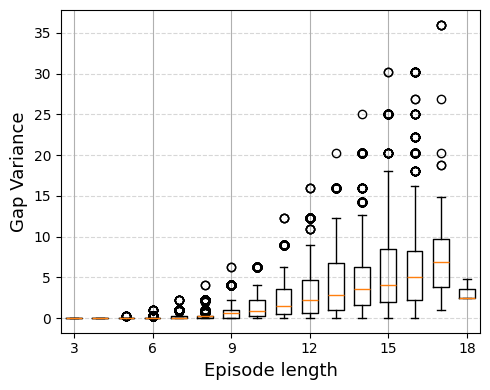

In [11]:
run_id = 'kfryeeez'
state_dim = 5
action_dim = 2
initial_inventory = 25
th = 600
ts = 25
types = ['twap', 'front_load', 'best_volume_2', 'best_volume_3', 'best_volume_4', 'ddqn']
run_ids = ['c1'] * (len(types)-1) + [run_id]
run_labels = ['A&C', 'aVWAP1', 'aVWAP2', 'aVWAP3', 'aVWAP4', 'DDQN']
best_labels = ['A&C', 'aVWAP1', 'aVWAP2', 'aVWAP3', 'aVWAP4', 'DDQN']

### --------------- #############################################

trader_times_full = np.concatenate(([0], np.arange(0, th + ts, ts)))
trader_times = trader_times_full[1:]

run_names = [f'{type}_{ri}' for type, ri in zip(types, run_ids)]
title = f'{run_id}'

### --------------- #############################################

plot_overview(
    run_names,
    run_labels,
    initial_inventory,
    trader_times,
    title,
    metric='executed',
    kde_only=True, 
    best_labels=best_labels, 
    run_id=run_id)

run_name = f'ddqn_{run_id}'
with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{run_name}.pkl', 'rb') as f:
    dic = pickle.load(f)
executed = dic['executed']

plot_mean_distance_boxplots(executed, trader_times_full, run_id)
plot_intra_mean_distance_boxplots(executed, trader_times_full, run_id)

### t-test

In [ ]:
compute_t_test(types, run_names, reference='ddqn')

T-test between ddqn and twap: t-statistic = 12.4261, p-value = 0.0000
Statistically significant difference between ddqn and twap (p < 0.05)


T-test between ddqn and front_load: t-statistic = 28.6044, p-value = 0.0000
Statistically significant difference between ddqn and front_load (p < 0.05)


T-test between ddqn and best_volume_4: t-statistic = 22.1021, p-value = 0.0000
Statistically significant difference between ddqn and best_volume_4 (p < 0.05)




: 

### Q values

unzip the saved model to load the NN weights

In [ ]:
class DummyEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = gym.spaces.Box(
            low=-1.0, high=1.0, shape=(state_dim,), dtype=float
        )
        self.action_space = gym.spaces.Discrete(action_dim)

    def reset(self):
        return self.observation_space.sample(), {}

    def step(self, action):
        return self.observation_space.sample(), 0.0, True, False, {}

dummy_env = DummyEnv()

# --- Define same policy as training ---
policy_kwargs = dict(
    net_arch=[30, 30, 30, 30, 30],
    activation_fn=nn.LeakyReLU,
)

# --- Recreate model with dummy env ---
model = DQN(
    policy="MlpPolicy",
    env=dummy_env,
    policy_kwargs=policy_kwargs,
    device="cpu",  # or "cuda"
)

# --- Load NN weights ---
path = f"/scratch/network/te6653/qrm_optimal_execution/save_model/ddqn_{run_id}/policy.pth"
state_dict = torch.load(path, map_location=model.device)
model.policy.load_state_dict(state_dict)
model.policy.eval()

# --- Now you can call the NN directly ---
obs = torch.zeros((1, state_dim))  # example input
q_values = model.policy.q_net(obs)
print("Q-values:", q_values)


Q-values: tensor([[-0.2623, -0.2399]], grad_fn=<AddmmBackward0>)


Pick the action: `show_action`

In [ ]:

# --- assume your SB3 DQN `model` is already created and loaded ---
model.policy.set_training_mode(False)
device = model.device

# ---- Parameters ----
times_min = -1.0
times_max = 1.0
inv_min   = -1.0
inv_max   =  1.0

price   = 0.0
ask_vol = 0.0
bid_vol = 0.0

# ---- Grids ----
n_grid = 101
times = np.linspace(times_min, times_max, n_grid, dtype=np.float32)
invs  = np.linspace(inv_min,   inv_max,   n_grid, dtype=np.float32)
T_raw, I_raw = np.meshgrid(times, invs)

# Percent axes for plotting
time_pct = (T_raw - times_min) / (times_max - times_min) * 100.0
inv_pct  = (I_raw  - inv_min)   / (inv_max   - inv_min)   * 100.0

# ---- Build (N, 5) batch of states from the raw grid ----
N = n_grid * n_grid
states = np.column_stack([
    I_raw.reshape(-1),            # inventory
    T_raw.reshape(-1),            # time
    np.full(N, price,   np.float32),
    np.full(N, ask_vol, np.float32),
    np.full(N, bid_vol, np.float32),
]).astype(np.float32)
obs = torch.as_tensor(states, device=device)

# ---- Get Q-values ----
with torch.no_grad():
    pi = model.policy
    try:
        if getattr(pi, "features_extractor", None) is not None:
            feats = pi.features_extractor(obs)
            q_tensor = pi.q_net(feats)
        else:
            feats = pi.extract_features(obs)
            q_tensor = pi.q_net(feats)
    except Exception:
        q_tensor = pi.q_net(obs)

q_values  = q_tensor.detach().cpu().numpy()
n_actions = q_values.shape[1]

# ---- Standard Plotly figure ----
fig = go.Figure()
for a in range(n_actions):
    Z = q_values[:, a].reshape(n_grid, n_grid)
    fig.add_trace(
        go.Surface(
            x=time_pct, y=inv_pct, z=Z,
            name=f"Action {a}",
            showscale=(a == 0),                 # one colorbar
            colorbar=(dict(title="Q-value") if a == 0 else None)
        )
    )

# show only the action you want initially
show_action = 1
for i in range(n_actions):
    fig.data[i].visible = (i == show_action)

fig.update_layout(
    scene=dict(
        xaxis_title="Time (%)",
        yaxis_title="Remaining Inventory (%)",
        zaxis_title="Q-value",
        aspectmode="cube",
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    scene_camera=dict(eye=dict(x=2.2, y=2.2, z=1.3)),  # optional starting view
)

# ---- Use FigureWidget so UI rotations sync back to Python ----
figw = go.FigureWidget(fig)
display(figw)

# ✅ Correct callback signature: (layout, value)
def _on_cam_change(layout, camera_value):
    print("Updated camera:", camera_value)

figw.layout.on_change(_on_cam_change, 'scene.camera')

# Button to print the current camera on demand
btn = widgets.Button(description="Print current camera")
out = widgets.Output()

def _print_cam(_):
    with out:
        print(figw.layout.scene.camera)

btn.on_click(_print_cam)
display(btn, out)

fig.update_layout(scene_camera=dict(eye=dict(x=2.2, y=2.2, z=1.3)))

# IMPORTANT: don't call fig.show() here; it opens a non-synced view.


FigureWidget({
    'data': [{'colorbar': {'title': {'text': 'Q-value'}},
              'name': 'Action 0',
              'showscale': True,
              'type': 'surface',
              'uid': 'a2b088a9-6c2f-40d6-9807-71df2b1467e0',
              'visible': False,
              'x': {'bdata': ('AAAAAPD/fz8EAABAAABAQPz/f0ACAK' ... 'IAAMBCAADCQgAAxEIAAMZCAADIQg=='),
                    'dtype': 'f4',
                    'shape': '101, 101'},
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'IAAMhCAADIQgAAyEIAAMhCAADIQg=='),
                    'dtype': 'f4',
                    'shape': '101, 101'},
              'z': {'bdata': ('0FlZPLA8XTzQH2E8kAJlPEDlaDxIyG' ... '+KzcO/VN7Gvxzvyb/m/8y/shDQvw=='),
                    'dtype': 'f4',
                    'shape': '101, 101'}},
             {'name': 'Action 1',
              'showscale': False,
              'type': 'surface',
              'uid': 'a42c88c4-3b55-4dcf-b562-2662439f6e8b',
              'visible': True,
   

Button(description='Print current camera', style=ButtonStyle())

Output()

In [ ]:
plotly_eye = {'x': 2.2, 'y': 2.2, 'z': 1.3}
elev, azim = plotly_eye_to_view_init(plotly_eye)
save_action_surface_pdf(elev, azim, show_action, q_values, n_grid, time_pct, inv_pct, filename=f"/scratch/network/te6653/qrm_optimal_execution/plots/q_values/{run_id}_q_surface_action{show_action}.pdf")

: 

## 4-dim: uuc7cxji

### General

[A&C] IS: mean=-0.365, std=0.652 

[aVWAP1] IS: mean=-0.413, std=0.279 

[aVWAP2] IS: mean=-0.408, std=0.342 

[aVWAP3] IS: mean=-0.400, std=0.388 

[aVWAP4] IS: mean=-0.399, std=0.437 

[DDQN] IS: mean=-0.325, std=0.594 

[A&C] 0.0000% of runs did not reach full inventory
[aVWAP1] 0.0000% of runs did not reach full inventory
[aVWAP2] 0.0000% of runs did not reach full inventory
[aVWAP3] 0.0050% of runs did not reach full inventory
    Missing volume: avg=4.00, std=0.00, max=4.00

[aVWAP4] 0.2650% of runs did not reach full inventory
    Missing volume: avg=2.51, std=1.91, max=9.00

[DDQN] 0.1550% of runs did not reach full inventory
    Missing volume: avg=6.77, std=4.90, max=19.00



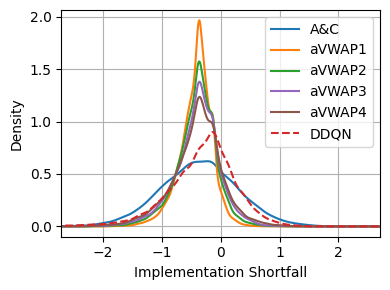

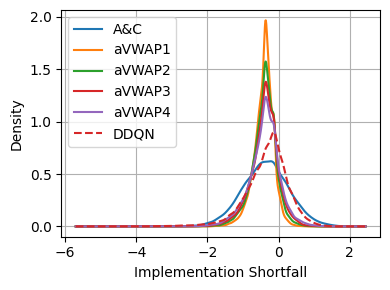

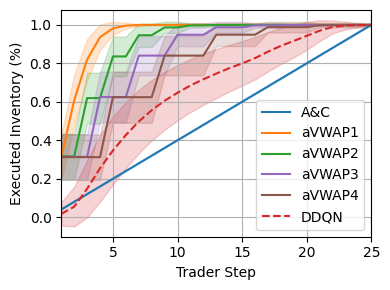

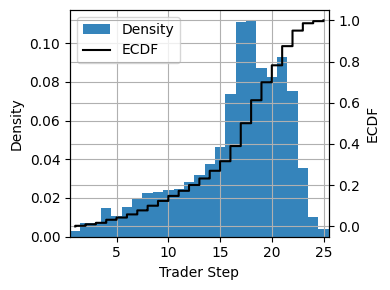

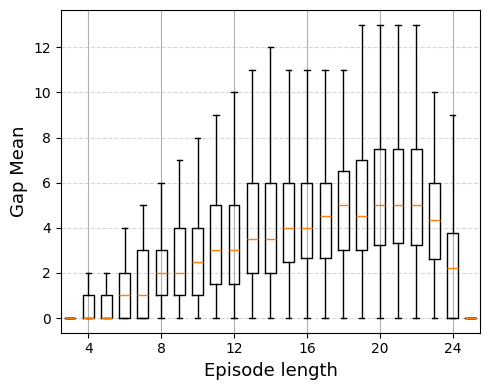

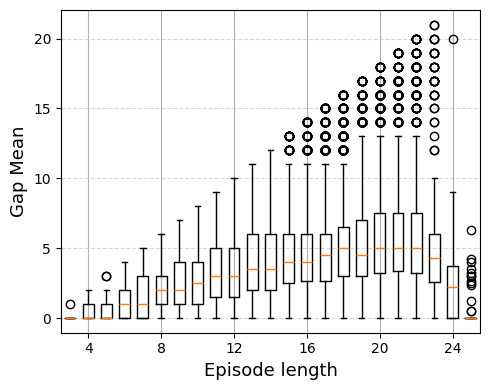

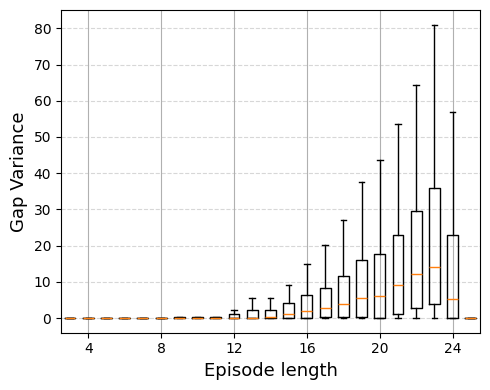

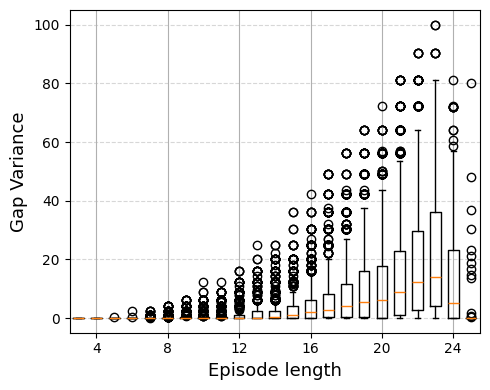

: 

In [ ]:
run_id = 'uuc7cxji'
state_dim = 5
action_dim = 2
initial_inventory = 25
th = 600
ts = 25
types = ['twap', 'front_load', 'best_volume_2', 'best_volume_3', 'best_volume_4', 'ddqn']
types = ['twap', 'front_load', 'best_volume_2', 'best_volume_3', 'best_volume_4', 'ddqn']
run_ids = ['c1'] * (len(types)-1) + [run_id]
run_labels = ['A&C', 'aVWAP1', 'aVWAP2', 'aVWAP3', 'aVWAP4', 'DDQN']
best_labels = ['A&C', 'aVWAP1', 'aVWAP2', 'aVWAP3', 'aVWAP4', 'DDQN']

### --------------- #############################################

trader_times_full = np.concatenate(([0], np.arange(0, th + ts, ts)))
trader_times = trader_times_full[1:]

run_names = [f'{type}_{ri}' for type, ri in zip(types, run_ids)]
title = f'{run_id}'

### --------------- #############################################

plot_overview(
    run_names,
    run_labels,
    initial_inventory,
    trader_times,
    title,
    metric='executed',
    kde_only=True, 
    best_labels=best_labels, 
    run_id=run_id)

run_name = f'ddqn_{run_id}'
with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{run_name}.pkl', 'rb') as f:
    dic = pickle.load(f)
executed = dic['executed']

plot_mean_distance_boxplots(executed, trader_times_full, run_id)
plot_intra_mean_distance_boxplots(executed, trader_times_full, run_id)

### t-test

In [ ]:
compute_t_test(types, run_names, reference='ddqn')

T-test between ddqn and twap: t-statistic = 6.3740, p-value = 0.0000
Statistically significant difference between ddqn and twap (p < 0.05)


T-test between ddqn and front_load: t-statistic = 19.0640, p-value = 0.0000
Statistically significant difference between ddqn and front_load (p < 0.05)


T-test between ddqn and best_volume_4: t-statistic = 14.1954, p-value = 0.0000
Statistically significant difference between ddqn and best_volume_4 (p < 0.05)




### Q values

unzip the saved model to load the NN weights

In [ ]:
class DummyEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = gym.spaces.Box(
            low=-1.0, high=1.0, shape=(state_dim,), dtype=float
        )
        self.action_space = gym.spaces.Discrete(action_dim)

    def reset(self):
        return self.observation_space.sample(), {}

    def step(self, action):
        return self.observation_space.sample(), 0.0, True, False, {}

dummy_env = DummyEnv()

# --- Define same policy as training ---
policy_kwargs = dict(
    net_arch=[30, 30, 30, 30, 30],
    activation_fn=nn.LeakyReLU,
)

# --- Recreate model with dummy env ---
model = DQN(
    policy="MlpPolicy",
    env=dummy_env,
    policy_kwargs=policy_kwargs,
    device="cpu",  # or "cuda"
)

# --- Load NN weights ---
path = f"/scratch/network/te6653/qrm_optimal_execution/save_model/ddqn_{run_id}/policy.pth"
state_dict = torch.load(path, map_location=model.device)
model.policy.load_state_dict(state_dict)
model.policy.eval()

# --- Now you can call the NN directly ---
obs = torch.zeros((1, state_dim))  # example input
q_values = model.policy.q_net(obs)
print("Q-values:", q_values)


Q-values: tensor([[-0.2623, -0.2399]], grad_fn=<AddmmBackward0>)


Pick the action: `show_action`

In [ ]:

# --- assume your SB3 DQN `model` is already created and loaded ---
model.policy.set_training_mode(False)
device = model.device

# ---- Parameters ----
times_min = -1.0
times_max = 1.0
inv_min   = -1.0
inv_max   =  1.0

price   = 0.0
ask_vol = 0.0
bid_vol = 0.0

# ---- Grids ----
n_grid = 101
times = np.linspace(times_min, times_max, n_grid, dtype=np.float32)
invs  = np.linspace(inv_min,   inv_max,   n_grid, dtype=np.float32)
T_raw, I_raw = np.meshgrid(times, invs)

# Percent axes for plotting
time_pct = (T_raw - times_min) / (times_max - times_min) * 100.0
inv_pct  = (I_raw  - inv_min)   / (inv_max   - inv_min)   * 100.0

# ---- Build (N, 5) batch of states from the raw grid ----
N = n_grid * n_grid
states = np.column_stack([
    I_raw.reshape(-1),            # inventory
    T_raw.reshape(-1),            # time
    np.full(N, price,   np.float32),
    np.full(N, ask_vol, np.float32),
    np.full(N, bid_vol, np.float32),
]).astype(np.float32)
obs = torch.as_tensor(states, device=device)

# ---- Get Q-values ----
with torch.no_grad():
    pi = model.policy
    try:
        if getattr(pi, "features_extractor", None) is not None:
            feats = pi.features_extractor(obs)
            q_tensor = pi.q_net(feats)
        else:
            feats = pi.extract_features(obs)
            q_tensor = pi.q_net(feats)
    except Exception:
        q_tensor = pi.q_net(obs)

q_values  = q_tensor.detach().cpu().numpy()
n_actions = q_values.shape[1]

# ---- Standard Plotly figure ----
fig = go.Figure()
for a in range(n_actions):
    Z = q_values[:, a].reshape(n_grid, n_grid)
    fig.add_trace(
        go.Surface(
            x=time_pct, y=inv_pct, z=Z,
            name=f"Action {a}",
            showscale=(a == 0),                 # one colorbar
            colorbar=(dict(title="Q-value") if a == 0 else None)
        )
    )

# show only the action you want initially
show_action = 1
for i in range(n_actions):
    fig.data[i].visible = (i == show_action)

fig.update_layout(
    scene=dict(
        xaxis_title="Time (%)",
        yaxis_title="Remaining Inventory (%)",
        zaxis_title="Q-value",
        aspectmode="cube",
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    scene_camera=dict(eye=dict(x=2.2, y=2.2, z=1.3)),  # optional starting view
)

# ---- Use FigureWidget so UI rotations sync back to Python ----
figw = go.FigureWidget(fig)
display(figw)

# ✅ Correct callback signature: (layout, value)
def _on_cam_change(layout, camera_value):
    print("Updated camera:", camera_value)

figw.layout.on_change(_on_cam_change, 'scene.camera')

# Button to print the current camera on demand
btn = widgets.Button(description="Print current camera")
out = widgets.Output()

def _print_cam(_):
    with out:
        print(figw.layout.scene.camera)

btn.on_click(_print_cam)
display(btn, out)

fig.update_layout(scene_camera=dict(eye=dict(x=2.2, y=2.2, z=1.3)))

# IMPORTANT: don't call fig.show() here; it opens a non-synced view.


FigureWidget({
    'data': [{'colorbar': {'title': {'text': 'Q-value'}},
              'name': 'Action 0',
              'showscale': True,
              'type': 'surface',
              'uid': 'a2b088a9-6c2f-40d6-9807-71df2b1467e0',
              'visible': False,
              'x': {'bdata': ('AAAAAPD/fz8EAABAAABAQPz/f0ACAK' ... 'IAAMBCAADCQgAAxEIAAMZCAADIQg=='),
                    'dtype': 'f4',
                    'shape': '101, 101'},
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'IAAMhCAADIQgAAyEIAAMhCAADIQg=='),
                    'dtype': 'f4',
                    'shape': '101, 101'},
              'z': {'bdata': ('0FlZPLA8XTzQH2E8kAJlPEDlaDxIyG' ... '+KzcO/VN7Gvxzvyb/m/8y/shDQvw=='),
                    'dtype': 'f4',
                    'shape': '101, 101'}},
             {'name': 'Action 1',
              'showscale': False,
              'type': 'surface',
              'uid': 'a42c88c4-3b55-4dcf-b562-2662439f6e8b',
              'visible': True,
   

Button(description='Print current camera', style=ButtonStyle())

Output()

In [ ]:
plotly_eye = {'x': 2.2, 'y': 2.2, 'z': 1.3}
elev, azim = plotly_eye_to_view_init(plotly_eye)
save_action_surface_pdf(elev, azim, show_action, q_values, n_grid, time_pct, inv_pct, filename=f"/scratch/network/te6653/qrm_optimal_execution/plots/q_values/{run_id}_q_surface_action{show_action}.pdf")

: 

## 5-dim: k3631p6d

### General

[A&C] IS: mean=-0.365, std=0.652 

[aVWAP1] IS: mean=-0.413, std=0.279 

[aVWAP2] IS: mean=-0.408, std=0.342 

[aVWAP3] IS: mean=-0.400, std=0.388 

[aVWAP4] IS: mean=-0.399, std=0.437 

[DDQN] IS: mean=-0.290, std=0.541 

[A&C] 0.0000% of runs did not reach full inventory
[aVWAP1] 0.0000% of runs did not reach full inventory
[aVWAP2] 0.0000% of runs did not reach full inventory
[aVWAP3] 0.0050% of runs did not reach full inventory
    Missing volume: avg=4.00, std=0.00, max=4.00

[aVWAP4] 0.2650% of runs did not reach full inventory
    Missing volume: avg=2.51, std=1.91, max=9.00

[DDQN] 0.0150% of runs did not reach full inventory
    Missing volume: avg=2.33, std=0.94, max=3.00



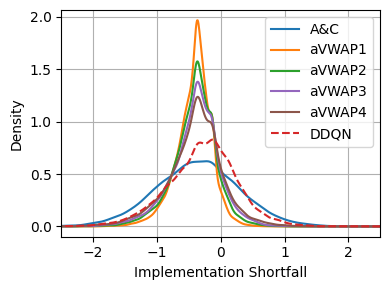

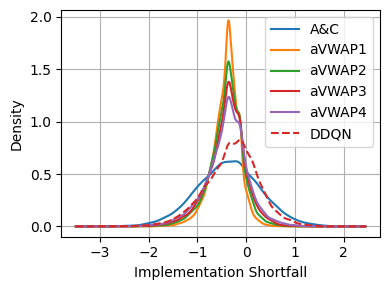

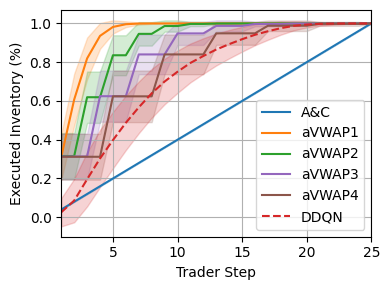

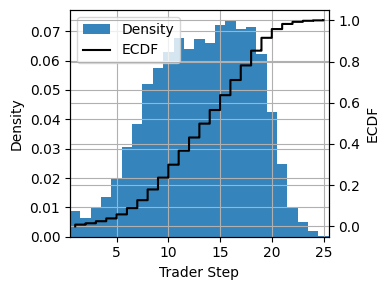

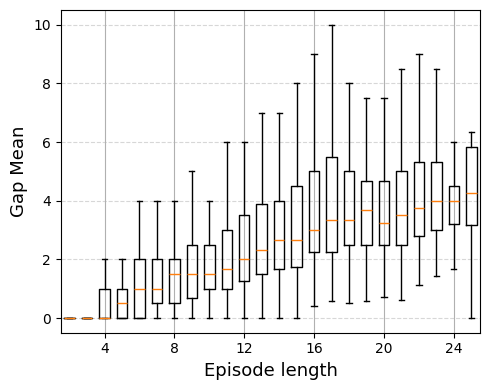

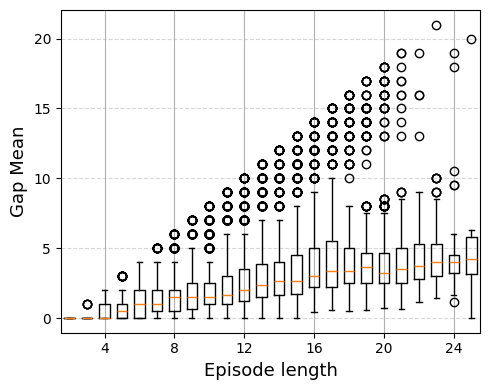

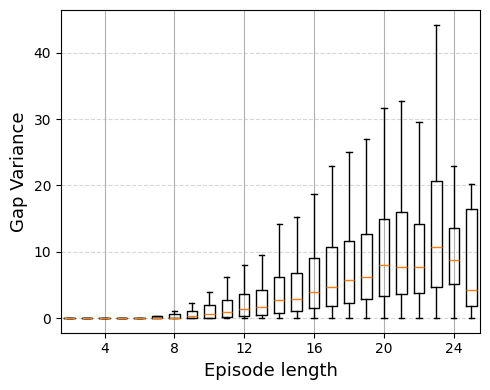

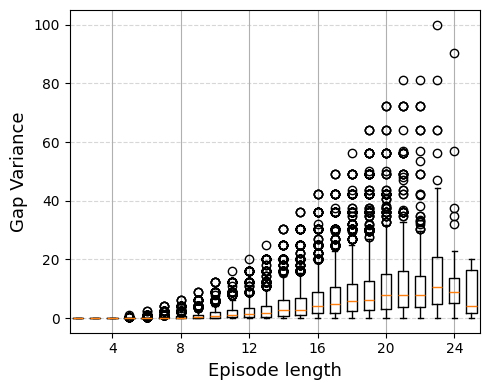

: 

In [ ]:
run_id = 'k3631p6d'
state_dim = 5
action_dim = 2
initial_inventory = 25
th = 600
ts = 25
types = ['twap', 'front_load', 'best_volume_2', 'best_volume_3', 'best_volume_4', 'ddqn']
run_ids = ['c1'] * (len(types)-1) + [run_id]
run_labels = ['A&C', 'aVWAP1', 'aVWAP2', 'aVWAP3', 'aVWAP4', 'DDQN']
best_labels = ['A&C', 'aVWAP1', 'aVWAP2', 'aVWAP3', 'aVWAP4', 'DDQN']

### --------------- #############################################

trader_times_full = np.concatenate(([0], np.arange(0, th + ts, ts)))
trader_times = trader_times_full[1:]

run_names = [f'{type}_{ri}' for type, ri in zip(types, run_ids)]
title = f'{run_id}'

### --------------- #############################################

plot_overview(
    run_names,
    run_labels,
    initial_inventory,
    trader_times,
    title,
    metric='executed',
    kde_only=True, 
    best_labels=best_labels, 
    run_id=run_id)

run_name = f'ddqn_{run_id}'
with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{run_name}.pkl', 'rb') as f:
    dic = pickle.load(f)
executed = dic['executed']

plot_mean_distance_boxplots(executed, trader_times_full, run_id)
plot_intra_mean_distance_boxplots(executed, trader_times_full, run_id)

### t-test

In [ ]:
compute_t_test(types, run_names, reference='ddqn')

T-test between ddqn and twap: t-statistic = 12.4261, p-value = 0.0000
Statistically significant difference between ddqn and twap (p < 0.05)


T-test between ddqn and front_load: t-statistic = 28.6044, p-value = 0.0000
Statistically significant difference between ddqn and front_load (p < 0.05)


T-test between ddqn and best_volume_4: t-statistic = 22.1021, p-value = 0.0000
Statistically significant difference between ddqn and best_volume_4 (p < 0.05)




: 

### Q values

unzip the saved model to load the NN weights

In [ ]:
class DummyEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = gym.spaces.Box(
            low=-1.0, high=1.0, shape=(state_dim,), dtype=float
        )
        self.action_space = gym.spaces.Discrete(action_dim)

    def reset(self):
        return self.observation_space.sample(), {}

    def step(self, action):
        return self.observation_space.sample(), 0.0, True, False, {}

dummy_env = DummyEnv()

# --- Define same policy as training ---
policy_kwargs = dict(
    net_arch=[30, 30, 30, 30, 30],
    activation_fn=nn.LeakyReLU,
)

# --- Recreate model with dummy env ---
model = DQN(
    policy="MlpPolicy",
    env=dummy_env,
    policy_kwargs=policy_kwargs,
    device="cpu",  # or "cuda"
)

# --- Load NN weights ---
path = f"/scratch/network/te6653/qrm_optimal_execution/save_model/ddqn_{run_id}/policy.pth"
state_dict = torch.load(path, map_location=model.device)
model.policy.load_state_dict(state_dict)
model.policy.eval()

# --- Now you can call the NN directly ---
obs = torch.zeros((1, state_dim))  # example input
q_values = model.policy.q_net(obs)
print("Q-values:", q_values)


Q-values: tensor([[-0.2623, -0.2399]], grad_fn=<AddmmBackward0>)


Pick the action: `show_action`

In [ ]:

# --- assume your SB3 DQN `model` is already created and loaded ---
model.policy.set_training_mode(False)
device = model.device

# ---- Parameters ----
times_min = -1.0
times_max = 1.0
inv_min   = -1.0
inv_max   =  1.0

price   = 0.0
ask_vol = 0.0
bid_vol = 0.0

# ---- Grids ----
n_grid = 101
times = np.linspace(times_min, times_max, n_grid, dtype=np.float32)
invs  = np.linspace(inv_min,   inv_max,   n_grid, dtype=np.float32)
T_raw, I_raw = np.meshgrid(times, invs)

# Percent axes for plotting
time_pct = (T_raw - times_min) / (times_max - times_min) * 100.0
inv_pct  = (I_raw  - inv_min)   / (inv_max   - inv_min)   * 100.0

# ---- Build (N, 5) batch of states from the raw grid ----
N = n_grid * n_grid
states = np.column_stack([
    I_raw.reshape(-1),            # inventory
    T_raw.reshape(-1),            # time
    np.full(N, price,   np.float32),
    np.full(N, ask_vol, np.float32),
    np.full(N, bid_vol, np.float32),
]).astype(np.float32)
obs = torch.as_tensor(states, device=device)

# ---- Get Q-values ----
with torch.no_grad():
    pi = model.policy
    try:
        if getattr(pi, "features_extractor", None) is not None:
            feats = pi.features_extractor(obs)
            q_tensor = pi.q_net(feats)
        else:
            feats = pi.extract_features(obs)
            q_tensor = pi.q_net(feats)
    except Exception:
        q_tensor = pi.q_net(obs)

q_values  = q_tensor.detach().cpu().numpy()
n_actions = q_values.shape[1]

# ---- Standard Plotly figure ----
fig = go.Figure()
for a in range(n_actions):
    Z = q_values[:, a].reshape(n_grid, n_grid)
    fig.add_trace(
        go.Surface(
            x=time_pct, y=inv_pct, z=Z,
            name=f"Action {a}",
            showscale=(a == 0),                 # one colorbar
            colorbar=(dict(title="Q-value") if a == 0 else None)
        )
    )

# show only the action you want initially
show_action = 0
for i in range(n_actions):
    fig.data[i].visible = (i == show_action)

fig.update_layout(
    scene=dict(
        xaxis_title="Time (%)",
        yaxis_title="Remaining Inventory (%)",
        zaxis_title="Q-value",
        aspectmode="cube",
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    scene_camera=dict(eye=dict(x=2.2, y=2.2, z=1.3)),  # optional starting view
)

# ---- Use FigureWidget so UI rotations sync back to Python ----
figw = go.FigureWidget(fig)
display(figw)

# ✅ Correct callback signature: (layout, value)
def _on_cam_change(layout, camera_value):
    print("Updated camera:", camera_value)

figw.layout.on_change(_on_cam_change, 'scene.camera')

# Button to print the current camera on demand
btn = widgets.Button(description="Print current camera")
out = widgets.Output()

def _print_cam(_):
    with out:
        print(figw.layout.scene.camera)

btn.on_click(_print_cam)
display(btn, out)

fig.update_layout(scene_camera=dict(eye=dict(x=2.2, y=2.2, z=1.3)))

# IMPORTANT: don't call fig.show() here; it opens a non-synced view.


FigureWidget({
    'data': [{'colorbar': {'title': {'text': 'Q-value'}},
              'name': 'Action 0',
              'showscale': True,
              'type': 'surface',
              'uid': '9fd81880-b114-4ba5-92c3-445eed653ada',
              'visible': True,
              'x': {'bdata': ('AAAAAPD/fz8EAABAAABAQPz/f0ACAK' ... 'IAAMBCAADCQgAAxEIAAMZCAADIQg=='),
                    'dtype': 'f4',
                    'shape': '101, 101'},
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'IAAMhCAADIQgAAyEIAAMhCAADIQg=='),
                    'dtype': 'f4',
                    'shape': '101, 101'},
              'z': {'bdata': ('0FlZPLA8XTzQH2E8kAJlPEDlaDxIyG' ... '+KzcO/VN7Gvxzvyb/m/8y/shDQvw=='),
                    'dtype': 'f4',
                    'shape': '101, 101'}},
             {'name': 'Action 1',
              'showscale': False,
              'type': 'surface',
              'uid': '83ba2d57-a423-4291-b013-b42cf94e7d99',
              'visible': False,
   

Button(description='Print current camera', style=ButtonStyle())

Output()

In [ ]:
plotly_eye = {'x': 2.2, 'y': 2.2, 'z': 1.3}
elev, azim = plotly_eye_to_view_init(plotly_eye)
save_action_surface_pdf(elev, azim, show_action, q_values, n_grid, time_pct, inv_pct, cmap='cividis', filename=f"/scratch/network/te6653/qrm_optimal_execution/plots/q_values/{run_id}_q_surface_action{show_action}.pdf")

: 

## 5-dim: lap51s8c [0, 0.5, 1.0]

### General

[A&C] IS: mean=-0.365, std=0.652 

[aVWAP1] IS: mean=-0.343, std=0.378 

[aVWAP2] IS: mean=-0.342, std=0.472 

[aVWAP3] IS: mean=-0.400, std=0.388 

[aVWAP4] IS: mean=-0.399, std=0.437 

[DDQN] IS: mean=-0.259, std=0.631 

[A&C] 0.0000% of runs did not reach full inventory
[aVWAP1] 0.0000% of runs did not reach full inventory
[aVWAP2] 0.0350% of runs did not reach full inventory
    Missing volume: avg=2.14, std=1.81, max=5.00

[aVWAP3] 0.0050% of runs did not reach full inventory
    Missing volume: avg=4.00, std=0.00, max=4.00

[aVWAP4] 0.2650% of runs did not reach full inventory
    Missing volume: avg=2.51, std=1.91, max=9.00

[DDQN] 0.0450% of runs did not reach full inventory
    Missing volume: avg=1.44, std=0.96, max=4.00



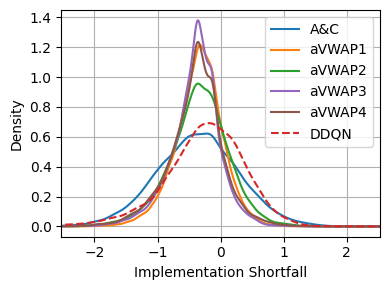

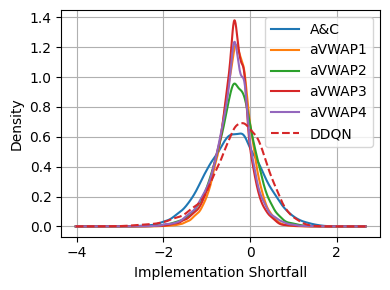

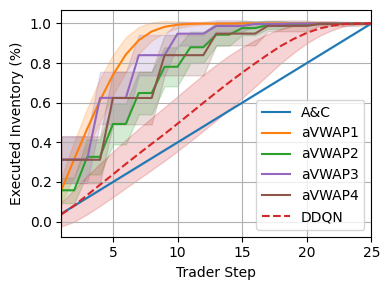

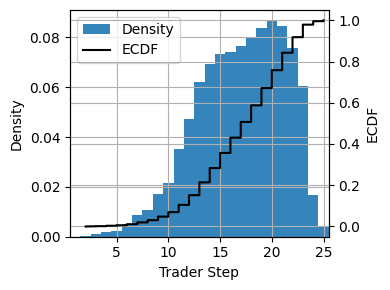

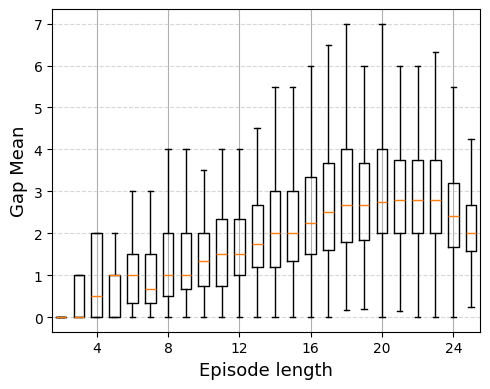

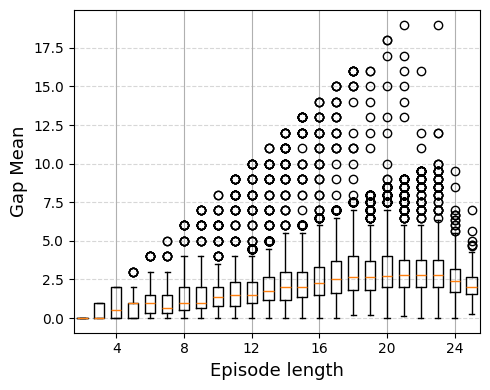

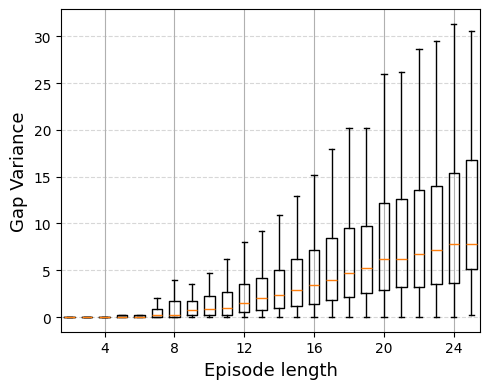

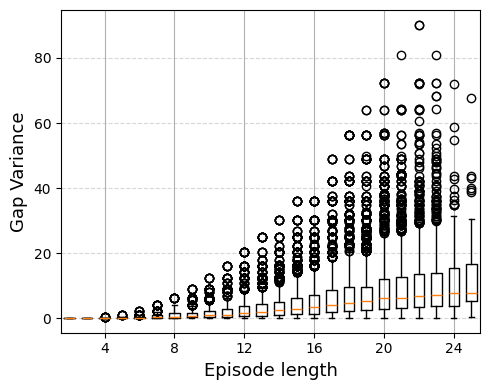

: 

In [ ]:
run_id = 'lap51s8c'
state_dim = 5
action_dim = 3
initial_inventory = 25
th = 600
ts = 25
types = ['twap', 'front_load', 'front_load_half', 'best_volume_half_2', 'best_volume_half_3', 'best_volume_4', 'ddqn']
types = ['twap', 'front_load_half', 'best_volume_half_2', 'best_volume_3', 'best_volume_4', 'ddqn']
run_ids = ['c1'] * (len(types)-1) + [run_id]
run_labels = ['A&C', 'aVWAP1', 'aVWAP2', 'aVWAP3', 'aVWAP4', 'DDQN']
best_labels = ['A&C', 'aVWAP1', 'aVWAP2', 'aVWAP3', 'aVWAP4', 'DDQN']

### --------------- #############################################

trader_times_full = np.concatenate(([0], np.arange(0, th + ts, ts)))
trader_times = trader_times_full[1:]

run_names = [f'{type}_{ri}' for type, ri in zip(types, run_ids)]
title = f'{run_id}'

### --------------- #############################################

plot_overview(
    run_names,
    run_labels,
    initial_inventory,
    trader_times,
    title,
    metric='executed',
    kde_only=True, 
    best_labels=best_labels, 
    run_id=run_id)

run_name = f'ddqn_{run_id}'
with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{run_name}.pkl', 'rb') as f:
    dic = pickle.load(f)
executed = dic['executed']

plot_mean_distance_boxplots(executed, trader_times_full, run_id)
plot_intra_mean_distance_boxplots(executed, trader_times_full, run_id)

### t-test

In [ ]:
compute_t_test(types, run_names, reference='ddqn')

T-test between ddqn and twap: t-statistic = 16.4579, p-value = 0.0000
Statistically significant difference between ddqn and twap (p < 0.05)


T-test between ddqn and front_load_half: t-statistic = 16.2176, p-value = 0.0000
Statistically significant difference between ddqn and front_load_half (p < 0.05)


T-test between ddqn and best_volume_half_2: t-statistic = 14.9016, p-value = 0.0000
Statistically significant difference between ddqn and best_volume_half_2 (p < 0.05)




: 

### Q values

unzip the saved model to load the NN weights

In [9]:
class DummyEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = gym.spaces.Box(
            low=-1.0, high=1.0, shape=(state_dim,), dtype=float
        )
        self.action_space = gym.spaces.Discrete(action_dim)

    def reset(self):
        return self.observation_space.sample(), {}

    def step(self, action):
        return self.observation_space.sample(), 0.0, True, False, {}

dummy_env = DummyEnv()

# --- Define same policy as training ---
policy_kwargs = dict(
    net_arch=[30, 30, 30, 30, 30],
    activation_fn=nn.LeakyReLU,
)

# --- Recreate model with dummy env ---
model = DQN(
    policy="MlpPolicy",
    env=dummy_env,
    policy_kwargs=policy_kwargs,
    device="cpu",  # or "cuda"
)

# --- Load NN weights ---
path = f"/scratch/network/te6653/qrm_optimal_execution/save_model/ddqn_{run_id}/policy.pth"
state_dict = torch.load(path, map_location=model.device)
model.policy.load_state_dict(state_dict)
model.policy.eval()

# --- Now you can call the NN directly ---
obs = torch.zeros((1, state_dim))  # example input
q_values = model.policy.q_net(obs)
print("Q-values:", q_values)


Q-values: tensor([[-0.2371, -0.2670, -0.2446]], grad_fn=<AddmmBackward0>)


Pick the action: `show_action`

In [12]:

# --- assume your SB3 DQN `model` is already created and loaded ---
model.policy.set_training_mode(False)
device = model.device

# ---- Parameters ----
times_min = -1.0
times_max = 1.0
inv_min   = -1.0
inv_max   =  1.0

price   = 0.0
ask_vol = 0.0
bid_vol = 0.0

# ---- Grids ----
n_grid = 101
times = np.linspace(times_min, times_max, n_grid, dtype=np.float32)
invs  = np.linspace(inv_min,   inv_max,   n_grid, dtype=np.float32)
T_raw, I_raw = np.meshgrid(times, invs)

# Percent axes for plotting
time_pct = (T_raw - times_min) / (times_max - times_min) * 100.0
inv_pct  = (I_raw  - inv_min)   / (inv_max   - inv_min)   * 100.0

# ---- Build (N, 5) batch of states from the raw grid ----
N = n_grid * n_grid
states = np.column_stack([
    I_raw.reshape(-1),            # inventory
    T_raw.reshape(-1),            # time
    np.full(N, price,   np.float32),
    np.full(N, ask_vol, np.float32),
    np.full(N, bid_vol, np.float32),
]).astype(np.float32)
obs = torch.as_tensor(states, device=device)

# ---- Get Q-values ----
with torch.no_grad():
    pi = model.policy
    try:
        if getattr(pi, "features_extractor", None) is not None:
            feats = pi.features_extractor(obs)
            q_tensor = pi.q_net(feats)
        else:
            feats = pi.extract_features(obs)
            q_tensor = pi.q_net(feats)
    except Exception:
        q_tensor = pi.q_net(obs)

q_values  = q_tensor.detach().cpu().numpy()
n_actions = q_values.shape[1]

# ---- Standard Plotly figure ----
fig = go.Figure()
for a in range(n_actions):
    Z = q_values[:, a].reshape(n_grid, n_grid)
    fig.add_trace(
        go.Surface(
            x=time_pct, y=inv_pct, z=Z,
            name=f"Action {a}",
            showscale=(a == 0),                 # one colorbar
            colorbar=(dict(title="Q-value") if a == 0 else None)
        )
    )

# show only the action you want initially
show_action = 2
for i in range(n_actions):
    fig.data[i].visible = (i == show_action)

fig.update_layout(
    scene=dict(
        xaxis_title="Time (%)",
        yaxis_title="Remaining Inventory (%)",
        zaxis_title="Q-value",
        aspectmode="cube",
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    scene_camera=dict(eye=dict(x=2.2, y=2.2, z=1.3)),  # optional starting view
)

# ---- Use FigureWidget so UI rotations sync back to Python ----
figw = go.FigureWidget(fig)
display(figw)

# ✅ Correct callback signature: (layout, value)
def _on_cam_change(layout, camera_value):
    print("Updated camera:", camera_value)

figw.layout.on_change(_on_cam_change, 'scene.camera')

# Button to print the current camera on demand
btn = widgets.Button(description="Print current camera")
out = widgets.Output()

def _print_cam(_):
    with out:
        print(figw.layout.scene.camera)

btn.on_click(_print_cam)
display(btn, out)

fig.update_layout(scene_camera=dict(eye=dict(x=2.2, y=2.2, z=1.3)))

# IMPORTANT: don't call fig.show() here; it opens a non-synced view.


FigureWidget({
    'data': [{'colorbar': {'title': {'text': 'Q-value'}},
              'name': 'Action 0',
              'showscale': True,
              'type': 'surface',
              'uid': '6d1fb34d-607e-47ae-80b8-db4e4801cfb1',
              'visible': False,
              'x': {'bdata': ('AAAAAPD/fz8EAABAAABAQPz/f0ACAK' ... 'IAAMBCAADCQgAAxEIAAMZCAADIQg=='),
                    'dtype': 'f4',
                    'shape': '101, 101'},
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'IAAMhCAADIQgAAyEIAAMhCAADIQg=='),
                    'dtype': 'f4',
                    'shape': '101, 101'},
              'z': {'bdata': ('gKp5PFDgZTxQFlI8sEs+PACCKjywtx' ... '9ulHW/anl9v0xEhb9j0JC/ogSevw=='),
                    'dtype': 'f4',
                    'shape': '101, 101'}},
             {'name': 'Action 1',
              'showscale': False,
              'type': 'surface',
              'uid': '981364f7-2b3c-47df-a550-12f52bc4f0ee',
              'visible': False,
  

Button(description='Print current camera', style=ButtonStyle())

Output()

In [ ]:
plotly_eye = {'x': 2.2, 'y': 2.2, 'z': 1.3}
elev, azim = plotly_eye_to_view_init(plotly_eye)
save_action_surface_pdf(elev, azim, show_action, q_values, n_grid, time_pct, inv_pct, filename=f"/scratch/network/te6653/qrm_optimal_execution/plots/q_values/{run_id}_q_surface_action{show_action}.pdf")

: 

## Comparing

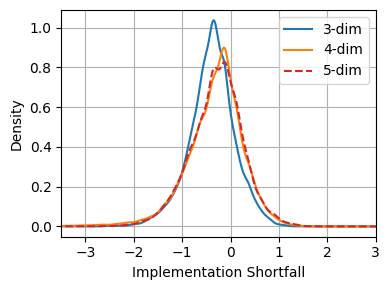

In [ ]:
with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/ddqn_kfryeeez.pkl', 'rb') as f:
    dic = pickle.load(f)

final_is_3 = np.array(dic['final_is'])
maxi = np.max(np.abs(final_is_3))

with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/ddqn_uuc7cxji.pkl', 'rb') as f:
    dic = pickle.load(f)

final_is_4 = np.array(dic['final_is'])
maxi = max(np.max(np.abs(final_is_4)), maxi)

with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/ddqn_k3631p6d.pkl', 'rb') as f:
    dic = pickle.load(f)

final_is_5 = np.array(dic['final_is'])
maxi = max(np.max(np.abs(final_is_5)), maxi)

x_kde = np.linspace(-maxi, maxi, 1000)
kde_3 = gaussian_kde(final_is_3)
y_kde_3 = kde_3(x_kde)
kde_4 = gaussian_kde(final_is_4)
y_kde_4 = kde_4(x_kde)
kde_5 = gaussian_kde(final_is_5)
y_kde_5 = kde_5(x_kde)

plt.figure(figsize=(4, 3))
plt.plot(x_kde, y_kde_3, label='3-dim')
plt.plot(x_kde, y_kde_4, label='4-dim')
plt.plot(x_kde, y_kde_5, label='5-dim', linestyle='--', color='C3')
plt.xlabel('Implementation Shortfall')
plt.ylabel('Density')
plt.xlim((-3.5, 3))

# plt.grid()
plt.legend()
plt.savefig(f'/scratch/network/te6653/qrm_optimal_execution/plots/overview/summary_is.pdf', bbox_inches='tight')
plt.show()

# Mid price trajectory graph

- DATA. `qrm_optimal_execution/mid_price_simulations/mid_price_path_{i}.parquet`.

- RUN. `lob_simulations.py` with `nb_graphs=14`, `file_name=f'mid_price_path_{param+1}'` and `time_end=80000`.

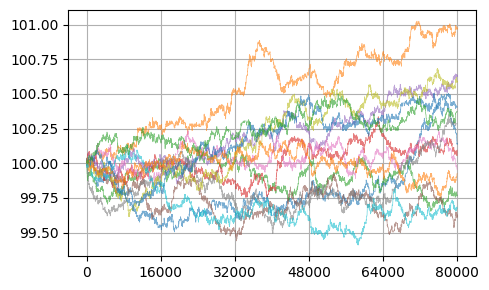

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,3))

for i in range(1,15):
    df1 = pd.read_parquet(f'mid_price_simulations/paper_{i}.parquet')
    if df1.p_mid.min() > 99:
        plt.plot(df1.time, df1.p_mid, linewidth=0.5, alpha=0.6)

ax = plt.gca()
N = 80_000              # or your max step
ticks = np.linspace(0, N, 6, dtype=int)  # 6 ticks
ax.set_xticks(ticks)
plt.grid()
plt.tight_layout()
plt.savefig('./plots/price_paths.pdf', bbox_inches='tight')

# Propagator Model Fit: Generate the data

- DATA. `qrm_optimal_execution/mid_price_simulations/trades_fit_propagator.csv.gz`.

- RUN. `lob_simulations.py` with `nb_graphs=1`, `file_name='lob_trades_fit_propagator'` and `time_end=int(1e7)`. This generates all the LOB in parquet file, we then have to filter out the needed information: times and prices just before trades and sign of the trades. The code below does this. It returns parquet or csv.gz.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.csv as pacsv
import gzip

df = pd.read_parquet('mid_price_simulations/lob_trades_fit_propagator.parquet')
print(f'Nb of trades: {len(df[df.event == 'market'])}. Percentage: {len(df[df.event == 'market']) / len(df) * 100}')

# Aux function
def extract_market_orders(df: pd.DataFrame, price_col: str = "price") -> pd.DataFrame:
    """
    Returns a DataFrame with:
      - time:      event time of each market order
      - sign:      +1 if side=='ask' (buy MKT), -1 if side=='bid' (sell MKT)
      - price_prev:price just BEFORE the market order (previous row's price)

    Assumes df has columns: 'time' (float), 'event' (str), 'side' (str), and the given price_col.
    """

    if price_col not in df.columns:
        raise ValueError(f"'{price_col}' not found in DataFrame columns: {df.columns.tolist()}")

    # Previous price for each row (price just before current event)
    df["price_prev"] = df[price_col].shift(1)

    # Filter market orders
    mo = df.loc[df["event"] == "market", ["time", "side", "price_prev"]].copy()

    # Trade sign: buy at ask => +1, sell at bid => -1
    mo["sign"] = np.where(mo["side"] == "ask",  +1,
                  np.where(mo["side"] == "bid", -1, np.nan))

    # Keep only required columns; drop rows where previous price is unavailable (first row edge case)
    mo = mo.dropna(subset=["price_prev"])[["time", "sign", "price_prev"]]

    return mo

# Extract needed info to fit the propagator model and save as parquet
market_df = extract_market_orders(df, price_col="p_mid")
market_df.to_parquet(
        "mid_price_simulations/trades_fit_propagator.parquet",
        engine="pyarrow",
        compression="zstd",    
        index=False
    )

# Transform parquet to csv.gz if needed 
def parquet_to_csv_gz(src_parquet: str, dst_csv_gz: str | None = None, batch_size: int = 65536):
    src = Path(src_parquet)
    if dst_csv_gz is None:
        dst_csv_gz = src.with_suffix(".csv.gz")
    dst = Path(dst_csv_gz)

    pf = pq.ParquetFile(src)

    # Open gzip in binary mode; let PyArrow write bytes to it
    with gzip.open(dst, "wb") as gz:
        sink = pa.output_stream(gz)
        first = True
        for batch in pf.iter_batches(batch_size=batch_size):
            table = pa.Table.from_batches([batch])
            pacsv.write_csv(
                table,
                sink,
                write_options=pacsv.WriteOptions(include_header=first)
            )
            first = False

    return str(dst)

out_path = parquet_to_csv_gz("./mid_price_simulations/trades_fit_propagator.parquet")
print("Wrote:", out_path)

FileNotFoundError: [Errno 2] No such file or directory: 'mid_price_simulations/lob_trades_fit_propagator.parquet'

# Avg. mid price buying best ask at regular time intervals

- DATA: `qrm_optimal_execution/buy_best_ask/best_volume_4_tr_{i}.pkl`.

- RUN: `run_test.py` with `train_run_id='tr_{i}'` for $i \in \{1, 0.85, 0.5, 0.25\}$, best volume agent `mod=4` and with `default.yaml` with the following parameters `time_horizon=78`, `trader_time_step=3`, `initial_inventory=10000`, `actions=[0, 1.0]`, `tick=0.01`, `arrival_price=100.005`, `theta=0.7` and vary `theta_reinit` in [1, 0.85, 0.5, 0.25].

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

## $\theta^{\text{reinit}} = 1.0$

In [3]:
T = 78
trader_time_step = 3
name_run = 'tr_1'

trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/best_volume_4_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']
executed = dic['executed']

# Prepare arrays
arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
arr_executed = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)

for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

for i, execs in executed.items():
    arr_executed[i, :len(execs)] = execs

# X-axis values
x_vals = range(1, len(trader_times))

# Compute means
mean_mid_prices_bv4_1 = np.nanmean(arr_mid_prices, axis=0)


## $\theta^{\text{reinit}} = 0.85$

In [4]:
T = 78
trader_time_step = 3
name_run = 'tr_85'

trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/best_volume_4_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']
executed = dic['executed']

# Prepare arrays
arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
arr_executed = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)

for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

for i, execs in executed.items():
    arr_executed[i, :len(execs)] = execs

# X-axis values
x_vals = range(1, len(trader_times))

# Compute means
mean_mid_prices_bv4 = np.nanmean(arr_mid_prices, axis=0)

## $\theta^{\text{reinit}} = 0.5$

In [5]:
T = 78
trader_time_step = 3
name_run = 'tr_5'

trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/best_volume_4_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']
executed = dic['executed']

# Prepare arrays
arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
arr_executed = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)

for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

for i, execs in executed.items():
    arr_executed[i, :len(execs)] = execs

# X-axis values
x_vals = range(1, len(trader_times))

# Compute means
mean_mid_prices_bv4_5 = np.nanmean(arr_mid_prices, axis=0)

## $\theta^{\text{reinit}} = 0.25$

In [6]:
T = 78
trader_time_step = 3
name_run = 'tr_25'

trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/best_volume_4_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']
executed = dic['executed']

# Prepare arrays
arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
arr_executed = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)

for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

for i, execs in executed.items():
    arr_executed[i, :len(execs)] = execs

# X-axis values
x_vals = range(1, len(trader_times))

# Compute means
mean_mid_prices_bv4_25 = np.nanmean(arr_mid_prices, axis=0)

## All together

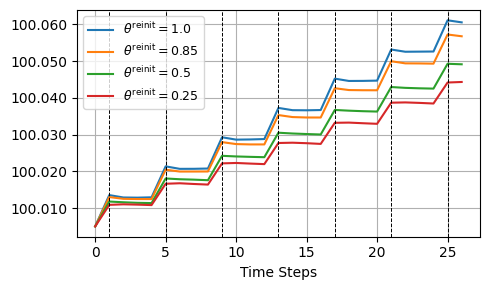

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter  # for plain numeric y-ticks

# --- 4. BV4 ---
fig, ax = plt.subplots(figsize=(5, 3))

x_vals = np.concatenate(([0], np.array(x_vals)))
mean_mid_prices_bv4_1  = np.concatenate(([100.005], np.array(mean_mid_prices_bv4_1)))
mean_mid_prices_bv4    = np.concatenate(([100.005], np.array(mean_mid_prices_bv4)))
mean_mid_prices_bv4_5  = np.concatenate(([100.005], np.array(mean_mid_prices_bv4_5)))
mean_mid_prices_bv4_25 = np.concatenate(([100.005], np.array(mean_mid_prices_bv4_25)))

ax.plot(x_vals, mean_mid_prices_bv4_1,  label=r'$\theta^{\text{reinit}}=1.0$')
ax.plot(x_vals, mean_mid_prices_bv4,    label=r'$\theta^{\text{reinit}}=0.85$')
ax.plot(x_vals, mean_mid_prices_bv4_5,  label=r'$\theta^{\text{reinit}}=0.5$')
ax.plot(x_vals, mean_mid_prices_bv4_25, label=r'$\theta^{\text{reinit}}=0.25$')

for i in range(7):
    ax.axvline(1 + i*4, color='k', linestyle='--', linewidth=0.7)

ax.set_xlabel('Time Steps')
ax.grid(True)
ax.legend(fontsize=9)

# ---- Show full numbers on y-axis (no +1e2) ----
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # e.g., 100.015

plt.tight_layout()
plt.savefig('./plots/theta_reinit.pdf', bbox_inches='tight')
plt.show()


# Market Impact Heatmap

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Long term heatmap

- DATA. `qrm_optimal_execution/market_impact_heatmaps/long_term_market_impact_heatmap.npz`.

- RUN. `theory_mr_event_heatmap.py` with `len_type='long'`

In [2]:
nb_grid = 60
thetas = np.linspace(0.5, 1.0, nb_grid)
theta_reinits = np.linspace(0.5, 1.0, nb_grid)

initial_price = 100.005
tick = 0.01
prefix = 'long_term_market_impact_heatmap'

# empirical price jumps after buying the best ask
df_price_jump_emp = pd.DataFrame(
    data=np.zeros((len(thetas), len(theta_reinits))),  # or np.nan
    index=thetas,
    columns=theta_reinits
)
# theoritical price jumps after buying the best ask
values = (1 + np.outer(thetas, theta_reinits)) * tick / 2
df_price_jump_theo = pd.DataFrame(
    data=values,
    index=thetas,
    columns=theta_reinits
)
# empirical price back to normal after buying the best ask
df_mr_emp = pd.DataFrame(
    data=np.zeros((len(thetas), len(theta_reinits))),
    index=thetas,
    columns=theta_reinits
)
# theoritical price back to normal after buying the best ask
values = tick * np.outer(thetas, np.ones(len(theta_reinits)))
df_mr_theo = pd.DataFrame(
    data=values,
    index=thetas,
    columns=theta_reinits
)

heatmap = np.zeros((len(thetas), len(theta_reinits)))
maxi_heatmap = -np.inf

path = '/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/'

# with np.load(path + f'{prefix}_heatmap_t_{i}_tr_{j}.npz') as data:
        #     prices_arr = data['arr']
with np.load(path + f'{prefix}.npz') as data:
    all_prices = data['arr']

for i, theta in enumerate(thetas):
    for j, theta_r in enumerate(theta_reinits):
        
        prices_arr = all_prices[i, j]
        # print('prices_arr shape', prices_arr.shape)
        # compute mean price
        mean_price = np.nanmean(prices_arr, axis=0)
        # average size of mid price jumps after buying the best ask
        price_jump = mean_price[0] - initial_price 
        df_price_jump_emp.iloc[i, j] = price_jump
        # average gap between initial price and prices back to normal after buying the best ask
        df_mr_emp.iloc[i, j] = mean_price[1] - initial_price
        # gap between price after buying and immediate reaction
        price_reaction = mean_price[-1] - mean_price[0]
        heatmap[i, j] = price_reaction

        max_abs_heatmap = max(np.max(np.abs(heatmap)), maxi_heatmap)

Error on Price Jump Empirical vs Theoretical (in %):
Max Error: 6.258%


Error on Price Back to Normal Empirical vs Theoretical (in %):
Max Error: 38.4%




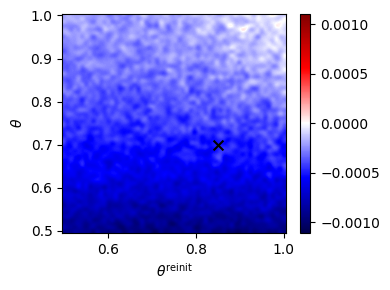

In [4]:
# PLOT
dx = (theta_reinits[1] - theta_reinits[0]) / 2
dy = (thetas[1] - thetas[0]) / 2
extent = [
    theta_reinits[0] - dx, theta_reinits[-1] + dx,  # x-min, x-max
    thetas[0] - dy, thetas[-1] + dy                 # y-min, y-max
]

plt.figure(figsize=(4, 3))
# ----- Left: bilinear -----
im_l = plt.imshow(
    heatmap[::-1], cmap='seismic',
    vmin=-max_abs_heatmap, vmax=max_abs_heatmap,
    extent=extent, interpolation='bicubic', aspect='auto'
)
plt.colorbar(im_l)
x_pt = np.linspace(theta_reinits[0], theta_reinits[-1], 100)
y_pt = 1 / (2 - x_pt)
# axes[0].plot(x_pt, y_pt, color='black', linestyle='--', label='Theoretical Reaction')
plt.xlabel(r'$\theta^{\text{reinit}}$')
plt.ylabel(r'$\theta$', rotation=90)
# axes[0].set_title("Bilinear interpolation")
plt.grid(False)
plt.scatter(0.85, 0.7, color='black', s=50, marker='x')

# # ----- Right: no interpolation -----
# im_r = axes[1].imshow(
#     heatmap[::-1], cmap='seismic',
#     vmin=-max_abs_heatmap, vmax=max_abs_heatmap,
#     extent=extent, interpolation='none', aspect='auto'
# )
# plt.colorbar(im_r, ax=axes[1])
# axes[1].plot(x_pt, y_pt, color='black', linestyle='--', label='Theoretical Reaction')
# axes[1].set_xlabel(r'$\mathbf{\theta}^{\text{reinit}}$')
# # axes[1].set_title("No interpolation")
# axes[1].grid(False)

plt.savefig(f'/home/te6653/research/qrm_optimal_execution/plots/{prefix}.pdf', bbox_inches='tight')

# Statistics
print("Error on Price Jump Empirical vs Theoretical (in %):")
df_error_jump = np.abs(df_price_jump_emp - df_price_jump_theo) / df_price_jump_theo * 100
print(f"Max Error: {round(np.max(df_error_jump), 3)}%")
print('\n')
print("Error on Price Back to Normal Empirical vs Theoretical (in %):")
df_error_mr = np.abs(df_mr_emp - df_mr_theo) / df_mr_theo * 100
print(f"Max Error: {round(np.max(df_error_mr), 3)}%")
print('\n')

# print("Price Jump Empirical:")
# print(df_price_jump_emp)
# print('\n')
# print("Gap Between Price After Buying and Normal Price Empirical:")
# print(df_mr_emp)

## Short term heatmap

- DATA. `qrm_optimal_execution/market_impact_heatmaps/short_term_market_impact_heatmap.npz`.

- RUN. `theory_mr_event_heatmap.npz` with `len_type='short'`

In [3]:
nb_grid = 60
thetas = np.linspace(0.5, 1.0, nb_grid)
theta_reinits = np.linspace(0.5, 1.0, nb_grid)

initial_price = 100.005
tick = 0.01
prefix = 'short_term_market_impact_heatmap'

# empirical price jumps after buying the best ask
df_price_jump_emp = pd.DataFrame(
    data=np.zeros((len(thetas), len(theta_reinits))),  # or np.nan
    index=thetas,
    columns=theta_reinits
)
# theoritical price jumps after buying the best ask
values = (1 + np.outer(thetas, theta_reinits)) * tick / 2
df_price_jump_theo = pd.DataFrame(
    data=values,
    index=thetas,
    columns=theta_reinits
)
# empirical price back to normal after buying the best ask
df_mr_emp = pd.DataFrame(
    data=np.zeros((len(thetas), len(theta_reinits))),
    index=thetas,
    columns=theta_reinits
)
# theoritical price back to normal after buying the best ask
values = tick * np.outer(thetas, np.ones(len(theta_reinits)))
df_mr_theo = pd.DataFrame(
    data=values,
    index=thetas,
    columns=theta_reinits
)

heatmap = np.zeros((len(thetas), len(theta_reinits)))
maxi_heatmap = -np.inf

path = '/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/'

# with np.load(path + f'{prefix}_heatmap_t_{i}_tr_{j}.npz') as data:
        #     prices_arr = data['arr']
with np.load(path + f'{prefix}.npz') as data:
    all_prices = data['arr']

for i, theta in enumerate(thetas):
    for j, theta_r in enumerate(theta_reinits):
        
        prices_arr = all_prices[i, j]
        # print('prices_arr shape', prices_arr.shape)
        # compute mean price
        mean_price = np.nanmean(prices_arr, axis=0)
        # average size of mid price jumps after buying the best ask
        price_jump = mean_price[0] - initial_price 
        df_price_jump_emp.iloc[i, j] = price_jump
        # average gap between initial price and prices back to normal after buying the best ask
        df_mr_emp.iloc[i, j] = mean_price[1] - initial_price
        # gap between price after buying and immediate reaction
        price_reaction = mean_price[1] - mean_price[0]
        heatmap[i, j] = price_reaction

        max_abs_heatmap = max(np.max(np.abs(heatmap)), maxi_heatmap)

Error on Price Jump Empirical vs Theoretical (in %):
Max Error: 5.347%


Error on Price Back to Normal Empirical vs Theoretical (in %):
Max Error: 38.655%




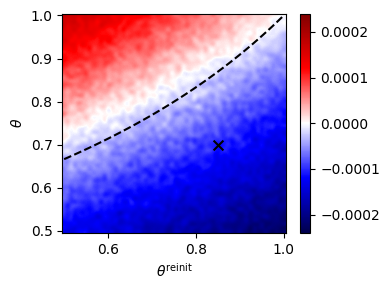

In [7]:
# PLOT
dx = (theta_reinits[1] - theta_reinits[0]) / 2
dy = (thetas[1] - thetas[0]) / 2
extent = [
    theta_reinits[0] - dx, theta_reinits[-1] + dx,  # x-min, x-max
    thetas[0] - dy, thetas[-1] + dy                 # y-min, y-max
]

plt.figure(figsize=(4, 3))
# ----- Left: bilinear -----
im_l = plt.imshow(
    heatmap[::-1], cmap='seismic',
    vmin=-max_abs_heatmap, vmax=max_abs_heatmap,
    extent=extent, interpolation='bicubic', aspect='auto'
)
plt.colorbar(im_l)
x_pt = np.linspace(theta_reinits[0], theta_reinits[-1], 100)
y_pt = 1 / (2 - x_pt)
plt.plot(x_pt, y_pt, color='black', linestyle='--', label='Theoretical Reaction')
plt.xlabel(r'$\theta^{\text{reinit}}$')
plt.ylabel(r'$\theta$', rotation=90)
# plt.xlabel(r'$\mathbf{\theta}^{\text{reinit}}$')
# plt.ylabel(r'$\mathbf{\theta}$', rotation=90)
# axes[0].set_title("Bilinear interpolation")
plt.grid(False)
plt.scatter(0.85, 0.7, color='black', s=50, marker='x')

# ----- Right: no interpolation -----
# im_r = axes[1].imshow(
#     heatmap[::-1], cmap='seismic',
#     vmin=-max_abs_heatmap, vmax=max_abs_heatmap,
#     extent=extent, interpolation='none', aspect='auto'
# )
# plt.colorbar(im_r, ax=axes[1])
# axes[1].plot(x_pt, y_pt, color='black', linestyle='--', label='Theoretical Reaction')
# axes[1].set_xlabel(r'$\mathbf{\theta}^{\text{reinit}}$')
# # axes[1].set_title("No interpolation")
# axes[1].grid(False)

plt.savefig(f'/home/te6653/research/qrm_optimal_execution/plots/{prefix}.pdf', bbox_inches='tight')

# Statistics
print("Error on Price Jump Empirical vs Theoretical (in %):")
df_error_jump = np.abs(df_price_jump_emp - df_price_jump_theo) / df_price_jump_theo * 100
print(f"Max Error: {round(np.max(df_error_jump), 3)}%")
print('\n')
print("Error on Price Back to Normal Empirical vs Theoretical (in %):")
df_error_mr = np.abs(df_mr_emp - df_mr_theo) / df_mr_theo * 100
print(f"Max Error: {round(np.max(df_error_mr), 3)}%")
print('\n')

# print("Price Jump Empirical:")
# print(df_price_jump_emp)
# print('\n')
# print("Gap Between Price After Buying and Normal Price Empirical:")
# print(df_mr_emp)

# Price evolution in event time after buying best ask for given tuples

- DATA. `qrm_optimal_execution/long_term_mean_reversion`

## $\theta=0.7, \theta^{\text{reinit}}=0.85$

- RUN. `theory_mr_event.py` with `file_prefix='qrm_paper'`

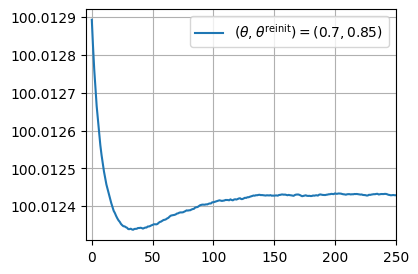

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(4, 3))
file_prefix = 'qrm_paper'
arr = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix}_market_impact.npz")
ax = plt.gca()
ax.plot(arr['arr'])
ax.grid(True)

# Disable scientific notation/offset on y
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')  # ensure plain decimals
plt.xlim((-5,250))
ax.legend([r'$(\theta, \theta^{\text{reinit}})=(0.7,0.85)$'], loc='best')

plt.savefig(f'/home/te6653/research/qrm_optimal_execution/plots/{file_prefix}_market_impact.pdf', bbox_inches='tight')

### Left leaf dynamics

- DATA. TBC

- RUN. `theory_mr_event_specific.py` with `leaf = 'left_leaf'` and `qrm_type='qrm_paper'`

Noise, as expected.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
max_nb_events = 200
file_prefix = 'left_leaf'
arr = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{max_nb_events}_{file_prefix}_market_impact.npz")
plt.plot(arr['arr'])
plt.grid()

### Middle leaf dynamics

- DATA. TBC

- RUN. `theory_mr_event_specific.py` with `leaf = 'middle_leaf'` and `qrm_type='qrm_paper'`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
file_prefix = 'middle_leaf_qrm_paper'
arr = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix}_market_impact.npz")
plt.plot(arr['arr'])
plt.grid()

- DATA. TBC

- RUN. `theory_mr_event_specific.py` with `leaf = 'middle_leaf'` and `qrm_type='ergodic'`

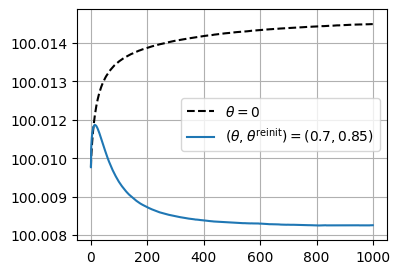

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

plt.figure(figsize=(4, 3))
ax = plt.gca()

# --- Series 1 ---
file_prefix_1 = 'middle_leaf_ergodic'
arr1 = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix_1}_market_impact.npz")['arr']
arr1[0] = 100.01
ax.plot(arr1, color='k', linestyle='--')

# --- Series 2 ---
file_prefix_2 = 'middle_leaf_qrm_paper'
arr2 = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix_2}_market_impact.npz")['arr']
arr2[0] = 100.01
ax.plot(arr2)

# --- Formatting: show full numbers (no +1e2), and 3 decimals like 100.015 ---
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# Make ticks land on multiples of 0.005 so 100.015 appears
ymin = float(min(arr1.min(), arr2.min()))
ymax = float(max(arr1.max(), arr2.max()))
pad = 0.0005  # tiny padding for aesthetics
ax.set_ylim(ymin - pad, ymax + pad)
ax.yaxis.set_major_locator(MultipleLocator(0.0013))

ax.grid(True)
ax.legend([r'$\theta=0$', r'$(\theta, \theta^{\text{reinit}})=(0.7,0.85)$'], loc='center right')

# Save (use a clear output name)
out_prefix = 'market_impact_compare'
plt.savefig(f'/home/te6653/research/qrm_optimal_execution/plots/{out_prefix}.pdf', bbox_inches='tight')


### Right leaf dynamics

- DATA. TBC

- RUN. `theory_mr_event_specific.py` with `leaf = 'right_leaf'` and `qrm_type='qrm_paper'`

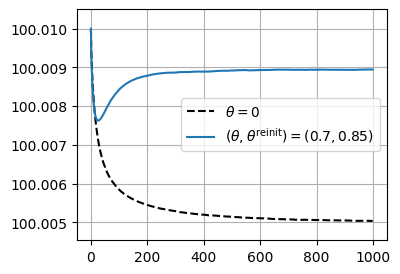

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

plt.figure(figsize=(4, 3))
ax = plt.gca()

# --- Series 1 ---
file_prefix_1 = 'right_leaf_ergodic'
arr1 = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix_1}_market_impact.npz")['arr']
arr1[0] = 100.01
ax.plot(arr1, color='k', linestyle='--')

# --- Series 2 ---
file_prefix_2 = 'right_leaf_qrm_paper'
arr2 = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix_2}_market_impact.npz")['arr']
arr2[0] = 100.01
ax.plot(arr2)

# --- Formatting: show full numbers (no +1e2), and 3 decimals like 100.015 ---
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# Make ticks land on multiples of 0.005 so 100.015 appears
ymin = float(min(arr1.min(), arr2.min()))
ymax = float(max(arr1.max(), arr2.max()))
pad = 0.0005
ax.set_ylim(ymin - pad, ymax + pad)
ax.yaxis.set_major_locator(MultipleLocator(0.001))

ax.grid(True)
ax.legend([r'$\theta=0$', r'$(\theta, \theta^{\text{reinit}})=(0.7,0.85)$'], loc='center right')

# Save
out_path = '/home/te6653/research/qrm_optimal_execution/plots/right_leaf_market_impact.pdf'
plt.savefig(out_path, bbox_inches='tight')


## $\theta=0.9, \theta^{\text{reinit}}=0.6$

- DATA. TBC

- RUN. `theory_mr_event.py` with `file_prefix='permanent'`

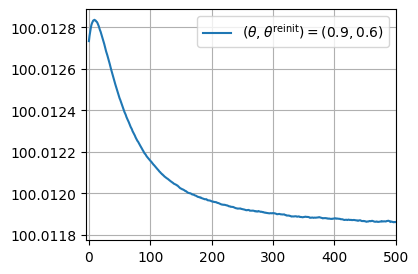

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(4, 3))
file_prefix = 'permanent'
arr = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix}_market_impact.npz")
ax = plt.gca()
ax.plot(arr['arr'])
ax.grid(True)

# Disable scientific notation/offset on y
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')  # ensure plain decimals
plt.xlim((-5,500))
ax.legend([r'$(\theta, \theta^{\text{reinit}})=(0.9,0.6)$'], loc='best')

plt.savefig(f'/home/te6653/research/qrm_optimal_execution/plots/{file_prefix}_market_impact.pdf', bbox_inches='tight')

No need for left leaf, it is also noise. 

### Middle leaf dynamics

- DATA. TBC

- RUN. `theory_mr_event_specific.py` with `leaf = 'middle_leaf'` and `qrm_type='permanent'`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
file_prefix = 'middle_leaf_permanent'
arr = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix}_market_impact.npz")
plt.plot(arr['arr'])
plt.grid()

### Right leaf dynamics

- DATA. TBC

- RUN. `theory_mr_event_specific.py` with `leaf = 'right_leaf'` and `qrm_type='permanent'`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
file_prefix = 'right_leaf_permanent'
arr = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix}_market_impact.npz")
plt.plot(arr['arr'])
plt.grid()

## Ergodic $\theta=0$

### Right Leaf

- DATA. TBC

- RUN. `theory_mr_event_specific.py` with `leaf = 'right_leaf'` and `qrm_type='ergodic'`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
file_prefix = 'right_leaf_ergodic'
arr = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix}_market_impact.npz")
plt.plot(arr['arr'])
plt.grid()

### Middle Leaf

- DATA. TBC

- RUN. `theory_mr_event_specific.py` with `leaf = 'middle_leaf'` and `qrm_type='ergodic'`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
file_prefix = 'middle_leaf_ergodic'
arr = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix}_market_impact.npz")
plt.plot(arr['arr'])
plt.grid()

### $\theta=0.5, \theta^{\text{reinit}}=0.5$

#### Right Leaf

- DATA. TBC

- RUN. `theory_mr_event_specific.py` with `leaf = 'right_leaf'` and `qrm_type='test'`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
file_prefix = 'right_leaf_test'
arr = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix}_market_impact.npz")
plt.plot(arr['arr'])
plt.grid()

#### Left Leaf

- DATA. TBC

- RUN. `theory_mr_event_specific.py` with `leaf = 'left_leaf'` and `qrm_type='test'`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
file_prefix = 'middle_leaf_test'
arr = np.load(f"/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/{file_prefix}_market_impact.npz")
plt.plot(arr['arr'])
plt.grid()

# RL Robustness parameter change heatmap

- DATA. `qrm_optimal_execution/rl_robustness`

- RUN. `run_test_heatmap.py` with `train_run_id = 'k3631p6d'`

Minimum relative error: 4.41% at theta=0.78, theta_reinit=0.50
Maximum relative error: 27.01% at theta=0.78, theta_reinit=0.94


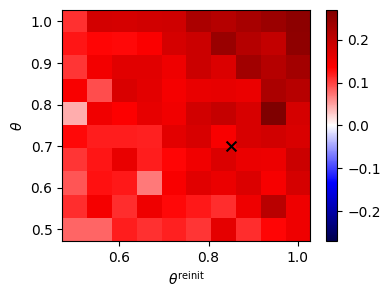

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_run_id = 'k3631p6d'
thetas = np.linspace(0.5, 1.0, 10)
theta_reinits = thetas.copy()

rel_mean_is_arr = np.load(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/relative_is_heatmap_{train_run_id}.npy')
ranking_arr = np.load(f'/scratch/network/te6653/qrm_optimal_execution/data_wandb/dictionaries/ranking_is_heatmap_{train_run_id}.npy')

dx = (theta_reinits[1] - theta_reinits[0]) / 2
dy = (thetas[1] - thetas[0]) / 2
extent = [
    theta_reinits[0] - dx, theta_reinits[-1] + dx,  # x-min, x-max
    thetas[0] - dy, thetas[-1] + dy                 # y-min, y-max
]

plt.figure(figsize=(4, 3))
# ----- Left: bilinear -----
max_abs_heatmap = np.max(np.abs(rel_mean_is_arr))
im_l = plt.imshow(
    rel_mean_is_arr[::-1], cmap='seismic',
    vmin=-max_abs_heatmap, vmax=max_abs_heatmap,
    extent=extent, aspect='auto'
)
plt.colorbar(im_l)
plt.scatter(0.85, 0.7, color='black', s=50, marker='x')
plt.xlabel(r'$\theta^{\text{reinit}}$')
plt.ylabel(r'$\theta$', rotation=90)

plt.savefig(f'/home/te6653/research/qrm_optimal_execution/plots/robustness_relative_error_heatmap.pdf', bbox_inches='tight')

print(f'Minimum relative error: {np.min(rel_mean_is_arr)*100:.2f}% at theta={thetas[np.unravel_index(np.argmin(rel_mean_is_arr), rel_mean_is_arr.shape)[0]]:.2f}, theta_reinit={theta_reinits[np.unravel_index(np.argmin(rel_mean_is_arr), rel_mean_is_arr.shape)[1]]:.2f}')
print(f'Maximum relative error: {np.max(rel_mean_is_arr)*100:.2f}% at theta={thetas[np.unravel_index(np.argmax(rel_mean_is_arr), rel_mean_is_arr.shape)[0]]:.2f}, theta_reinit={theta_reinits[np.unravel_index(np.argmax(rel_mean_is_arr), rel_mean_is_arr.shape)[1]]:.2f}')

In [ ]:
N = ranking_arr.shape[0]
identical_rank = True
for i in range(N):
    for j in range(N):
        ranks = ranking_arr[i, j]
        if not np.all([3,2,1,0] == ranks):
            print(f"Error at ({i}, {j}): {ranks}")
            identical_rank = False
if identical_rank:
    print("All rankings follow 1) DQN 2) TWAP 3) BV4 4) BV1.")
else:
    print("Some rankings differ from the expected [3,2,1,0].")

All rankings follow 1) DQN 2) TWAP 3) BV4 4) BV1.


: 

# QRM Stats

In [ ]:
run_id = 'stats_tts_3'

with open(f'data_wandb/dictionaries/constant_0_{run_id}.pkl', 'rb') as f:
    dic = pickle.load(f)

lob = dic['lob'][0]
print('** Time Simulated', round(lob['time'].iloc[-1]/3600, 2), 'hours \n')
print(f"** Average Inter-event Time {round(np.float64(np.mean(lob['time'].diff().dropna())), 2)} s. (std. {round(np.float64(np.std(lob['time'].diff().dropna())), 2)} s.)")
print('   i.e.', round(1 / np.mean(lob['time'].diff().dropna()), 2), 'events per second in average \n')
price_changes = lob['p_mid'].diff() != 0
change_times = lob.loc[price_changes, 'time'].values
inter_times = np.diff(change_times)
avg_inter_time = inter_times.mean() if len(inter_times) > 0 else np.nan
avg_inter_time = np.float64(avg_inter_time)
std_inter_time = inter_times.std() if len(inter_times) > 0 else np.nan
std_inter_time = np.float64(std_inter_time)
print(f"** Average inter-time between mid price changes: {round(avg_inter_time, 2)} s. (std. {round(std_inter_time, 2)} s.) \n")
price_changes = lob['p_mid'].diff() != 0
change_indices = lob.index[price_changes].to_numpy()
events_between_changes = np.diff(change_indices)
mean_events = events_between_changes.mean() if len(events_between_changes) > 0 else np.nan
std_events = events_between_changes.std() if len(events_between_changes) > 0 else np.nan
print(f"** Mean number of events between mid price changes: {mean_events:.2f} (std. {std_events:.2f}) \n")
lob['second'] = lob['time'].astype(int)
events_per_second = lob.groupby('second').size()
max_events = events_per_second.max()
print(f"** Maximum number of events in a 1-second period: {max_events} (helpful infor for max_events parameters) \n")

** Time Simulated 5.56 hours 

** Average Inter-event Time 0.15 s. (std. 0.15 s.)
   i.e. 6.85 events per second in average 

** Average inter-time between mid price changes: 13.17 s. (std. 29.3 s.) 

** Mean number of events between mid price changes: 90.25 (std. 207.31) 

** Maximum number of events in a 1-second period: 20 (helpful infor for max_events parameters) 



# Playing

In [1]:
import sys
import os
import numpy as np 
import pandas as pd
from pathlib import Path
from datetime import datetime
from numba import njit

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))


from pathlib import Path
import sys

cur = Path.cwd().resolve()
while cur != cur.parent and not (cur / 'src').exists():
    cur = cur.parent

src_path = (cur / 'src').resolve()
assert src_path.exists(), f"src introuvable depuis {Path.cwd()}"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("SRC on sys.path ->", src_path)

from qrm_rl.configs.config import load_config
from qrm_rl.runner import RLRunner
from qrm_rl.agents.benchmark_strategies import BestVolumeAgent
from qrm_core.sampling import sample_stationary_lob, update_LOB
from qrm_core.engine import simulate_QRM_jit
from qrm_core.intensity import IntensityTable



def to_dataframe(times, p_mids, p_refs, sides, depths, events, redrawn, states, K):
    # Labels → categoricals (cheap)
    side_labels  = np.array(['', 'bid', 'ask'], dtype=object)
    event_labels = np.array(['', 'limit', 'cancel', 'market', 'trader'], dtype=object)
    side_cat  = pd.Categorical(side_labels[sides],  categories=['bid','ask'])
    event_cat = pd.Categorical(event_labels[events], categories=['limit','cancel','market','trader'])

    # Base df
    df = pd.DataFrame({
        'time':    times,
        'p_mid':   p_mids,
        'p_ref':   p_refs,
        'side':    side_cat,
        'depth':   depths,
        'event':   event_cat,
        'redrawn': redrawn.astype(bool, copy=False),
    }, copy=False)

    # --- Build q_* without hstack/copies ---
    # Make a DataFrame that *views* `states` (avoid copies if it's a 2D contiguous array)
    q_df = pd.DataFrame(states, copy=False)

    # Column order: bids reversed, asks as-is (logical reindex; inexpensive)
    order = list(range(K-1, -1, -1)) + list(range(K, 2*K))
    q_df = q_df.iloc[:, order]  # reorders column labels; usually no data copy

    # Name columns
    bid_names = [f"q_bid{i+1}" for i in range(K)][::-1]  # q_bidK ... q_bid1
    ask_names = [f"q_ask{i+1}" for i in range(K)]        # q_ask1 ... q_askK
    q_df.columns = bid_names + ask_names

    # Concatenate once (still a copy, but only once and without building q_block first)
    out = pd.concat([df, q_df], axis=1, copy=False)
    return out


""" 
GENERAL DESCRIPTION:

    HERE WE TRY TO UNDERSTAND WHY PRICES ALWAYS MEAN REVERT ON THE LONG TERM 
    We anayze how mid price evolves in the middle leaf of Fig. 1

    File used to generate mid price evolution for ONE tuple after buying the best ask
    for different values of theta and theta_reinit in EVENT TIME. 
    Similar to theory_mr_event_heatmap.py but for ONE SINGLE (theta, theta_reinit).
    This is very quick to run (much quicker than in physical time).

    The main parameters to set are: 
        - max_nb_events: number of events to log AFTER buying the best ask
        - episodes: number of repetitions for each (theta, theta_reinit) pair
        - nb_grid: number of points in the grid for theta and theta_reinit (total jobs = nb_grid^2)
        - one_spread: if True, force the initial LOB to have one spread
    BE CAREFUL: 
        - with the path to save the results (make sure the directory exists and you have write permission)
"""



def main(leaf, qrm_type, max_nb_events=50):
    # ----------------------------

    if qrm_type == 'qrm_paper':
        theta = 0.7
        theta_r = 0.85
    elif qrm_type == 'permanent':
        theta = 0.9
        theta_r = 0.6
    elif qrm_type == 'test':
        theta = 0
        theta_r = 0.
    else:
        raise ValueError("qrm_type must be 'qrm_paper' or 'permanent'")

    file_prefix = f"{leaf}_{qrm_type}"

    if leaf == 'middle_leaf':
        theta_first = 1
        theta_r_first = 0
    elif leaf == 'right_leaf':
        theta_first = 0.
        theta_r_first = 0.5 # anything works

    max_nb_events = 200
    episodes = 1
    one_spread = True
    arr_all_runs = np.empty((episodes, max_nb_events), dtype=float)

    K = 3
    t0 = 0.
    p_ref = 100.005
    tick = 0.01
    aes = [836, 1068, 1069]
    inv_bid = np.load('calibration_data/invariant_distribution/qrm_paper.npy')
    inv_ask = np.load('calibration_data/invariant_distribution/qrm_paper.npy')
    inten_arr = np.load('calibration_data/intensity_table/qrm_paper.npy')
    K, Q1, *_ = inten_arr.shape
    inten_table = IntensityTable(max_depth=K, max_queue=Q1-1)
    inten_table._data = inten_arr
    rate_int_all = np.transpose(inten_table._data, (2,0,1,3)).copy()

    jobs = [(0, 0, theta, theta_r)]

    total = len(jobs)
    done = 0
    failures = 0
    start_time = datetime.now()
    print(f"Starting sweep over {total} jobs at {start_time}.\n")


    for k, args in enumerate(jobs, start=1):
        i, j, theta, theta_r = args

        for l in range(episodes):
            
            # initial lob state
            lob0 = np.empty(2*K, np.int8)
            if one_spread:
                while True:
                    lob0[:K]   = sample_stationary_lob(inv_bid, np.empty((0,), np.int8))
                    lob0[K:] = sample_stationary_lob(inv_ask, np.empty((0,), np.int8))
                    bid_idx = next((i for i in range(K) if lob0[i]>0), None)
                    nz = np.flatnonzero(lob0[K:])
                    ask_idx = K + nz[0] if len(nz) > 0 else None
                    ask_idx_second = K + nz[1] if len(nz) > 1 else None
                    if bid_idx == 0 and ask_idx == K and ask_idx_second == (K+1):
                        break
            
            else:
                lob0[:K]   = sample_stationary_lob(inv_bid, np.empty((0,), np.int8))
                lob0[K:] = sample_stationary_lob(inv_ask, np.empty((0,), np.int8))
            
            # simulate buying best ask
            ask_idx = next((i for i in range(K, 2*K) if lob0[i]>0), None) # identify best ask
            if ask_idx is None:
                raise ValueError("Sampled empty LOB")
            lob0[ask_idx] = 0 # buy best ask
            # middle leaf corresponds to theta=1 and theta_r=0
            new_pmid, new_pref, state, redrawn = update_LOB( K, p_ref, lob0, 1,
                                                            theta_first, theta_r_first, tick,
                                                            inv_bid, inv_ask, aes)
            
                
            times, p_mids, p_refs, sides, depths, events, redrawns, states = simulate_QRM_jit(t0,
                                                                                        new_pmid,
                                                                                        new_pref,
                                                                                        state,
                                                                                        rate_int_all,
                                                                                        tick,
                                                                                        theta,
                                                                                        theta_r,
                                                                                        1,
                                                                                        inv_bid,
                                                                                        inv_ask, 
                                                                                        max_nb_events+2, 
                                                                                        aes, 
                                                                                        max_nb_events=max_nb_events
                                                                                        )

            arr_all_runs[l,:] = p_mids

            df = to_dataframe(times, p_mids, p_refs, sides, depths, events, redrawns, states, K)

            return df

SRC on sys.path -> /home/te6653/research/qrm_optimal_execution/src


In [2]:
seed = 2025
np.random.seed(seed)
@njit
def _init_numba(seed): np.random.seed(seed)
_init_numba(seed)

leaf = 'right_leaf'  # 'middle_leaf' or 'right_leaf'
qrm_type = 'qrm_paper'  # 'qrm_paper', 'permanent', or 'test'
df = main(leaf, qrm_type)

df.p_mid.values

Starting sweep over 1 jobs at 2025-10-13 18:27:24.160268.



array([100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 ,
       100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 ,
       100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 ,
       100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 ,
       100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 ,
       100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.01 , 100.005,
       100.005, 100.005, 100.005, 100.005, 100.005, 100.015, 100.015,
       100.015, 100.015, 100.015, 100.015, 100.015, 100.015, 100.015,
       100.015, 100.015, 100.015, 100.015, 100.015, 100.015, 100.015,
       100.015, 100.015, 100.015, 100.015, 100.015, 100.015, 100.015,
       100.015, 100.015, 100.015, 100.015, 100.01 , 100.01 , 100.01 ,
       100.01 , 100.01 , 100.01 , 100.01 , 100.005, 100.005, 100.005,
       100.005, 100.005, 100.015, 100.015, 100.015, 100.015, 100.015,
       100.015, 100.015, 100.015, 100.015, 100.015, 100.015, 100.015,
       100.015, 100.

In [ ]:
df.iloc[:50]

,time,p_mid,p_ref,side,depth,event,redrawn,q_bid3,q_bid2,q_bid1,q_ask1,q_ask2,q_ask3
0,0.005782,100.010,100.005,bid,1,cancel,False,37,12,5,0,12,26
1,0.031409,100.010,100.005,bid,1,limit,False,37,12,6,0,12,26
2,0.227239,100.010,100.005,bid,3,cancel,False,36,12,6,0,12,26
3,0.644382,100.010,100.005,bid,3,limit,False,37,12,6,0,12,26
4,0.690886,100.010,100.005,bid,1,cancel,False,37,12,5,0,12,26
5,0.872506,100.010,100.005,ask,2,cancel,False,37,12,5,0,11,26
6,1.026371,100.010,100.005,ask,2,cancel,False,37,12,5,0,10,26
7,1.141569,100.010,100.005,bid,3,cancel,False,36,12,5,0,10,26
8,1.222378,100.010,100.005,ask,2,cancel,False,36,12,5,0,9,26
9,1.265994,100.010,100.005,ask,2,cancel,False,36,12,5,0,8,26


: 

# Invariant Distribution

pi shape (3, 51)


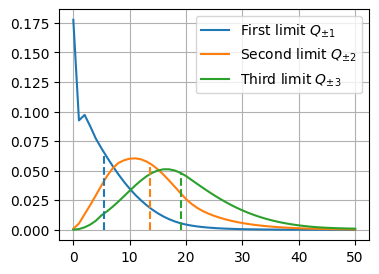

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pi = np.load('calibration_data/invariant_distribution/qrm_paper.npy')
print('pi shape', pi.shape)
K = 3 
plt.figure(figsize=(4, 3))
colors = ['C0', 'C1', 'C2']
for i in range(K):
        pi_i = pi[i]
        avg = np.mean(pi_i)
        plt.plot(pi_i, color=colors[i])

plt.grid()
plt.legend([r"First limit $Q_{\pm 1}$", r"Second limit $Q_{\pm 2}$", r"Third limit $Q_{\pm 3}$"], loc='best')
l = [0.065, 0.055, 0.048]
for i in range(K):
        pi_i = pi[i]
        avg = np.dot(pi_i, np.arange(len(pi_i)))
        plt.plot([avg, avg], [0, l[i]], linestyle='--', color=colors[i])

plt.savefig(f'/home/te6653/research/qrm_optimal_execution/plots/invariant_distribution.pdf', bbox_inches='tight')

# Learning Curves

## TD Loss

/tmp/ipykernel_2517396/2313481529.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


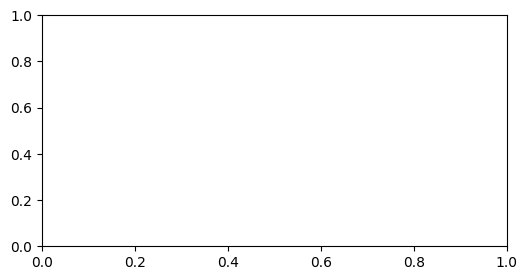

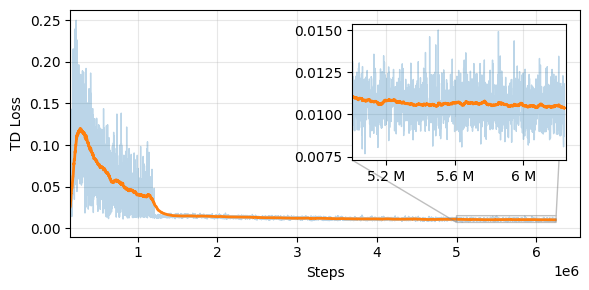

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import EngFormatter, MaxNLocator

def ema_smooth(steps, values, smoothing=0.9, mode="index"):
    """
    EMA smoothing.
    mode:
      - "index": classic EMA over index (W&B-like visual smoothing)
                 ema[i] = s * ema[i-1] + (1-s) * y[i]
      - "time" : time-weighted EMA with decay scaled by median Δstep
                 w_i = s ** (Δstep_i / ref_dt), where ref_dt = median(Δstep)

    smoothing in [0,1). Larger -> smoother. (e.g., 0.9 heavy smoothing)
    """
    steps = np.asarray(steps, dtype=float)
    values = np.asarray(values, dtype=float)

    # Keep finite values only
    m = np.isfinite(steps) & np.isfinite(values)
    steps, values = steps[m], values[m]

    # Ensure sorted by step
    order = np.argsort(steps)
    steps, values = steps[order], values[order]

    if len(values) == 0:
        return steps, values
    if len(values) == 1:
        return steps, values.copy()

    ema = np.empty_like(values, dtype=float)
    ema[0] = values[0]

    if mode == "index":
        s = float(smoothing)
        for i in range(1, len(values)):
            ema[i] = s * ema[i-1] + (1.0 - s) * values[i]
    elif mode == "time":
        # Scale decay by typical step size so 'smoothing' means something
        d = np.diff(steps)
        # Guard against zeros/negatives
        d[d <= 0] = np.nan
        ref_dt = np.nanmedian(d)
        if not np.isfinite(ref_dt) or ref_dt <= 0:
            ref_dt = 1.0
        s = float(smoothing)
        for i in range(1, len(values)):
            dt = steps[i] - steps[i-1]
            if dt <= 0:
                dt = ref_dt
            w = s ** (dt / ref_dt)   # if s=0.9 and dt=ref_dt -> w=0.9
            ema[i] = w * ema[i-1] + (1.0 - w) * values[i]
    else:
        raise ValueError("mode must be 'index' or 'time'")

    return steps, ema


# ---- Your data ----
td_loss = pd.read_csv("/scratch/network/te6653/qrm_optimal_execution/learning_curve_data/td_loss.csv")
x = td_loss['Step'].to_numpy()
y = td_loss['ddqn_k3631p6d - train/loss'].to_numpy()

# Smooth (index-based EMA is usually best for SB3 logs)
steps_s, ema = ema_smooth(x, y, smoothing=0.99, mode="index")

# ---- Choose your zoom window (edit these) ----
ZOOM_XLIM = (int(5.0e6), 6_250_000)  # <-- set your custom [xmin, xmax]

# Helper: compute a padded y-lim from data inside the zoom window
def zoom_ylim(x_main, curves, xlim):
    xmin, xmax = xlim
    m = (x_main >= xmin) & (x_main <= xmax)
    vals = []
    for c in curves:
        vals.append(np.asarray(c)[m])
    vals = np.concatenate(vals)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return None
    vmin, vmax = np.min(vals), np.max(vals)
    pad = 0.05 * (vmax - vmin if vmax > vmin else (abs(vmax) + 1.0))
    return (vmin - pad, vmax + pad)

# ---- Plot main figure ----
fig, ax = plt.subplots(figsize=(6, 3))
# ---- Your data ----
td_loss = pd.read_csv("/scratch/network/te6653/qrm_optimal_execution/learning_curve_data/td_loss.csv")
x = td_loss['Step'].to_numpy()
y = td_loss['ddqn_k3631p6d - train/loss'].to_numpy()

# Smooth (index-based EMA is usually best for SB3 logs)
steps_s, ema = ema_smooth(x, y, smoothing=0.99, mode="index")

# ---- Choose your zoom window (edit these) ----
ZOOM_XLIM = (int(5.0e6), 6_250_000)  # <-- set your custom [xmin, xmax]

# Helper: compute a padded y-lim from data inside the zoom window
def zoom_ylim(x_main, curves, xlim):
    xmin, xmax = xlim
    m = (x_main >= xmin) & (x_main <= xmax)
    vals = []
    for c in curves:
        vals.append(np.asarray(c)[m])
    vals = np.concatenate(vals)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return None
    vmin, vmax = np.min(vals), np.max(vals)
    pad = 0.05 * (vmax - vmin if vmax > vmin else (abs(vmax) + 1.0))
    return (vmin - pad, vmax + pad)

# ---- Plot main figure ----
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x, y, alpha=0.3, linewidth=1, label='raw')
ax.plot(steps_s, ema, linewidth=2, label='EMA (s=0.99, index)')
ax.set_xlabel('Steps')
ax.set_ylabel('TD Loss')
ax.set_xlim((150000, None))
ax.grid(True, alpha=0.3)
# ax.legend()

# ---- Inset (zoom) axes ----
in_ax = inset_axes(ax, width="42%", height="60%", loc="upper right", borderpad=1.0)
in_ax.plot(x, y, alpha=0.3, linewidth=1)
in_ax.plot(steps_s, ema, linewidth=2)

# Apply zoom limits
in_ax.set_xlim(*ZOOM_XLIM)
yl = zoom_ylim(steps_s, [ema, y], ZOOM_XLIM)
if yl is not None:
    in_ax.set_ylim(*yl)

# Make x tick labels one-line and compact (e.g., 6.25 M)
in_ax.xaxis.set_major_formatter(EngFormatter())   # uses SI prefixes: k,M,G,...
in_ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
in_ax.get_xaxis().get_offset_text().set_visible(False)  # hide any scientific offset

# Optional: label just the inset x-axis units
# in_ax.set_xlabel('Steps (M)', fontsize=8, labelpad=1)

# Ticks/grid styling in inset (optional)
in_ax.grid(True, alpha=0.3)
# in_ax.set_title("Zoom", fontsize=9, pad=2)

# Draw rectangle & connectors showing the zoomed region on the main axes
try:
    ax.indicate_inset_zoom(in_ax)
except Exception:
    ax.axvspan(ZOOM_XLIM[0], ZOOM_XLIM[1], alpha=0.08)

plt.tight_layout()
plt.savefig(f'/home/te6653/research/qrm_optimal_execution/plots/td_loss.pdf', bbox_inches='tight')
plt.show()


## Final reward

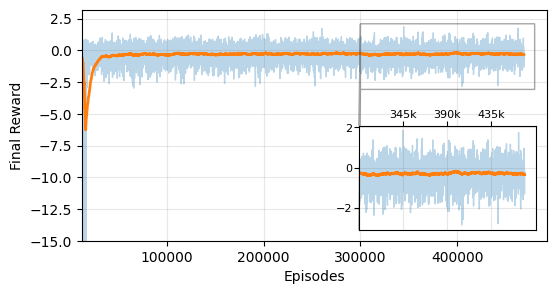

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FixedLocator, MaxNLocator, FuncFormatter

# ---------- EMA ----------
def ema_smooth(steps, values, smoothing=0.9, mode="index"):
    steps = np.asarray(steps, dtype=float)
    values = np.asarray(values, dtype=float)
    m = np.isfinite(steps) & np.isfinite(values)
    steps, values = steps[m], values[m]
    order = np.argsort(steps)
    steps, values = steps[order], values[order]
    if len(values) <= 1:
        return steps, values.copy()
    ema = np.empty_like(values, dtype=float)
    ema[0] = values[0]
    if mode == "index":
        s = float(smoothing)
        for i in range(1, len(values)):
            ema[i] = s * ema[i-1] + (1.0 - s) * values[i]
    elif mode == "time":
        d = np.diff(steps); d[d <= 0] = np.nan
        ref_dt = np.nanmedian(d); ref_dt = ref_dt if (np.isfinite(ref_dt) and ref_dt > 0) else 1.0
        s = float(smoothing)
        for i in range(1, len(values)):
            dt = steps[i] - steps[i-1]; dt = dt if dt > 0 else ref_dt
            w = s ** (dt / ref_dt)
            ema[i] = w * ema[i-1] + (1.0 - w) * values[i]
    else:
        raise ValueError("mode must be 'index' or 'time'")
    return steps, ema

def zoom_ylim(x_main, curves, xlim):
    xmin, xmax = xlim
    m = (x_main >= xmin) & (x_main <= xmax)
    vals = np.concatenate([np.asarray(c)[m] for c in curves])
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return None
    vmin, vmax = np.min(vals), np.max(vals)
    pad = 0.05 * (vmax - vmin if vmax > vmin else (abs(vmax) + 1.0))
    return (vmin - pad, vmax + pad)

# ---------- Data ----------
df = pd.read_csv("/scratch/network/te6653/qrm_optimal_execution/learning_curve_data/final_reward.csv")
x = df['Episode'].to_numpy()
y = df['ddqn_k3631p6d - Final Reward'].to_numpy()
steps_s, ema = ema_smooth(x, y, smoothing=0.99, mode="index")

# Zoom range
ZOOM_XLIM = (300_000, 480_000)

# Compact formatter: e.g., 350000 -> "350k"
k_formatter = FuncFormatter(lambda v, pos: f"{int(round(v/1_000))}k")

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x, y, alpha=0.30, linewidth=1, label='raw')
ax.plot(steps_s, ema, linewidth=2, label='EMA (s=0.99, index)')
ax.set_xlabel('Episodes')
ax.set_ylabel('Final Reward')
ax.grid(True, alpha=0.3)
ax.set_xlim((12000, None))
ax.set_ylim((-15, None))

# Inset (bottom-right)
in_ax = inset_axes(ax, width="38%", height="45%", loc="lower right", borderpad=0.8)
in_ax.set_zorder(5)
in_ax.set_facecolor("white")  # ensure labels are readable over main ticks
in_ax.plot(x, y, alpha=0.30, linewidth=1)
in_ax.plot(steps_s, ema, linewidth=2)

# Apply zoom limits + tidy y
in_ax.set_xlim(*ZOOM_XLIM)
yl = zoom_ylim(steps_s, [ema, y], ZOOM_XLIM)
if yl is not None:
    in_ax.set_ylim(*yl)

# ---- NO OVERLAP: move inset x labels to TOP and use interior ticks ----
xmin, xmax = ZOOM_XLIM
xr = xmax - xmin
xticks = [xmin + 0.25*xr, xmin + 0.50*xr, xmin + 0.75*xr]  # interior positions
in_ax.xaxis.set_major_locator(FixedLocator(xticks))
in_ax.xaxis.set_major_formatter(k_formatter)
in_ax.get_xaxis().get_offset_text().set_visible(False)

# put inset x tick labels on top; hide bottom ticks to avoid collision with main axis
in_ax.tick_params(axis='x', labeltop=True, top=True, labelbottom=False, bottom=False, labelsize=8, pad=1)
# keep y sparse too
in_ax.yaxis.set_major_locator(MaxNLocator(nbins=3, prune='both'))
in_ax.tick_params(axis='y', labelsize=8, pad=1)

in_ax.grid(True, alpha=0.3)

# rectangle + connectors
try:
    ax.indicate_inset_zoom(in_ax, edgecolor="0.3")
except Exception:
    ax.axvspan(ZOOM_XLIM[0], ZOOM_XLIM[1], alpha=0.08)

# plt.tight_layout()
plt.savefig('/home/te6653/research/qrm_optimal_execution/plots/final_reward.pdf', bbox_inches='tight')
plt.show()
